# Credit Card Fraud

En este notebook se analiza un conjunto de datos de transacciones con tarjeta de crédito con el objetivo de **detectar operaciones fraudulentas** mediante modelos de *Machine Learning* supervisado.

El flujo de trabajo será el siguiente:

1. **Análisis exploratorio de datos (AED)**  
   - Entender la estructura del dataset y las variables disponibles.  
   - Analizar la distribución de la clase objetivo (fraude / no fraude).  
   - Explorar distribuciones de variables relevantes y posibles patrones.

2. **Preprocesamiento**  
   - Selección y transformación de variables (por ejemplo, escalado de `Amount` y `Time`).  
   - Tratamiento del desbalanceo de clases (fraude es una clase minoritaria).

3. **Modelado**  
   - Entrenamiento de varios modelos de clasificación.  
   - Evaluación con métricas adecuadas para datos desbalanceados.  

4. **Conclusiones**  
   - Interpretación de los resultados.  
   - Posibles mejoras y líneas de trabajo futuras.

## 1. Configuración e importación de librerías

En esta sección se importan las librerías necesarias y se fija la configuración general (semilla, estilo de gráficos, etc.).

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import time
from collections import Counter
import shap
import random

from imblearn import FunctionSampler
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    average_precision_score
)
from sklearn.metrics import precision_recall_curve

import warnings
warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)

pd.set_option("display.max_columns", None)

df = pd.read_csv('creditcard.csv')

experiment_results = []

best_model_info = {
    "metric": -np.inf,
    "metric_name": "f1_fraud",
    "model": None,
    "model_name": None,
    "sampler": None,
    "threshold": None,
    "threshold_type": None,
    "metrics": {}
}

## 2. Carga del conjunto de datos

Se carga el dataset original de transacciones con tarjeta de crédito.  
El fichero suele llamarse `creditcard.csv` y contiene, entre otras:

- Variables `V1`–`V28`: componentes principales resultantes de una transformación PCA.
- `Time`: segundos transcurridos desde la primera transacción del conjunto.
- `Amount`: importe de la transacción.
- `Class`: variable objetivo (0 = no fraude, 1 = fraude).

In [21]:
df = pd.read_csv("creditcard.csv")  # o la ruta que corresponda

print("Forma del dataset (filas, columnas):", df.shape)

df.head()

Forma del dataset (filas, columnas): (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [22]:
print("Información general del dataframe:\n")
df.info()


Información general del dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     2848

In [23]:
print("Número máximo de nulos en una columna:", df.isnull().sum().max())

num_duplicados = df.duplicated().sum()
print("Número de filas duplicadas:", num_duplicados)

df.describe().T


Número máximo de nulos en una columna: 0
Número de filas duplicadas: 1081


,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.175161e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.384974e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.094852e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,1.021879e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.494498e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.620335e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.149614e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.414189e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


## 3. Análisis exploratorio

### 3.1. Distribución de la variable objetivo (`Class`)

Antes de entrar al detalle de las variables, es importante entender cómo está distribuida la clase objetivo.  
En problemas de fraude lo habitual es que la clase positiva (fraude) sea muy minoritaria, lo que genera un fuerte **desbalanceo**.


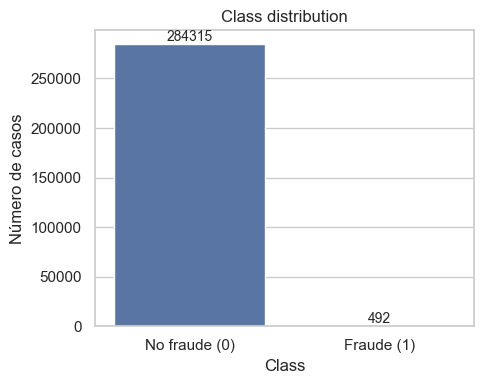

In [24]:
sns.set(style='whitegrid')

class_counts = df['Class'].value_counts()

plt.figure(figsize=(5, 4))
ax = sns.barplot(x=class_counts.index, y=class_counts.values)

plt.title('Class distribution')
plt.ylabel('Número de casos')
plt.xticks([0, 1], ["No fraude (0)", "Fraude (1)"])

for i, v in enumerate(class_counts.values):
    ax.text(
        i,                      
        v,
        f'{v}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

Podemos observar que:

- La gran mayoría de transacciones pertenecen a la clase **0 (no fraude)**.
- El número de transacciones etiquetadas como **1 (fraude)** es muy pequeño en comparación.

Este desbalanceo tendrá un impacto importante en el modelado:

- Métricas como la *accuracy* pueden ser engañosas.
- Será necesario usar estrategias específicas (re-muestreo, `class_weight`, métricas como PR-AUC, etc.) que se tratarán más adelante.

### 3.2. Distribución de `Amount` y `Time`

En esta sección analizamos la distribución de:

- `Amount`: importe de la transacción.
- `Time`: segundos transcurridos desde la primera transacción del conjunto.

El objetivo es:
- Detectar posibles valores extremos (*outliers*).
- Entender si las distribuciones están muy sesgadas.
- Tener contexto para decidir si es necesario aplicar transformaciones o escalado específico.

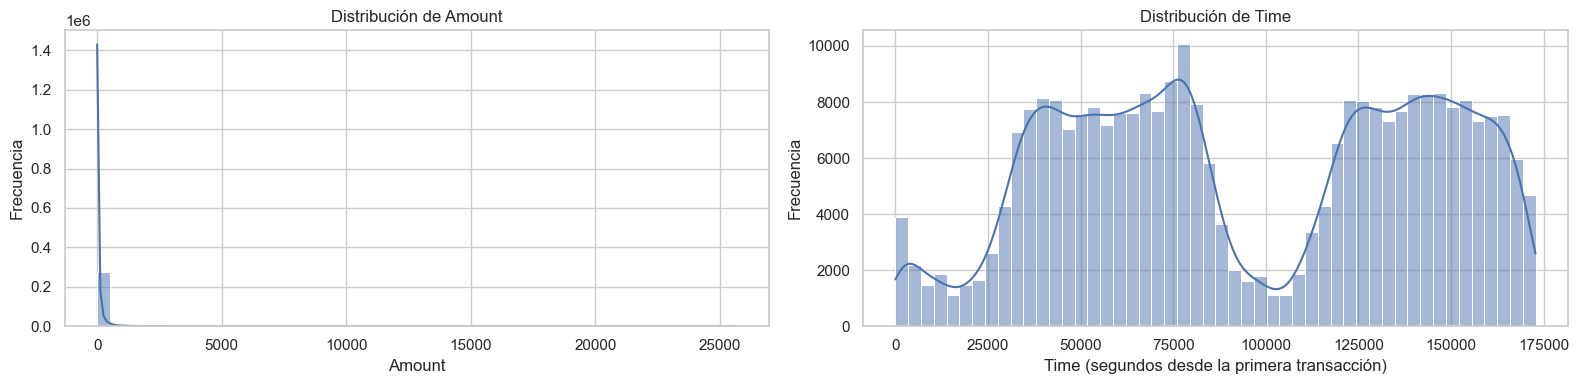

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

# Distribución de Amount
sns.histplot(df["Amount"], bins=50, kde=True, ax=ax[0])
ax[0].set_title("Distribución de Amount")
ax[0].set_xlabel("Amount")
ax[0].set_ylabel("Frecuencia")

# Distribución de Time
sns.histplot(df["Time"], bins=50, kde=True, ax=ax[1])
ax[1].set_title("Distribución de Time")
ax[1].set_xlabel("Time (segundos desde la primera transacción)")
ax[1].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

### 3.3. Distribución de `Amount` y `Time` por clase

También es interesante ver si `Amount` y `Time` se comportan de forma diferente para:

- Transacciones legítimas (`Class = 0`)
- Transacciones fraudulentas (`Class = 1`)

Para ello, vamos a usar lineplots.


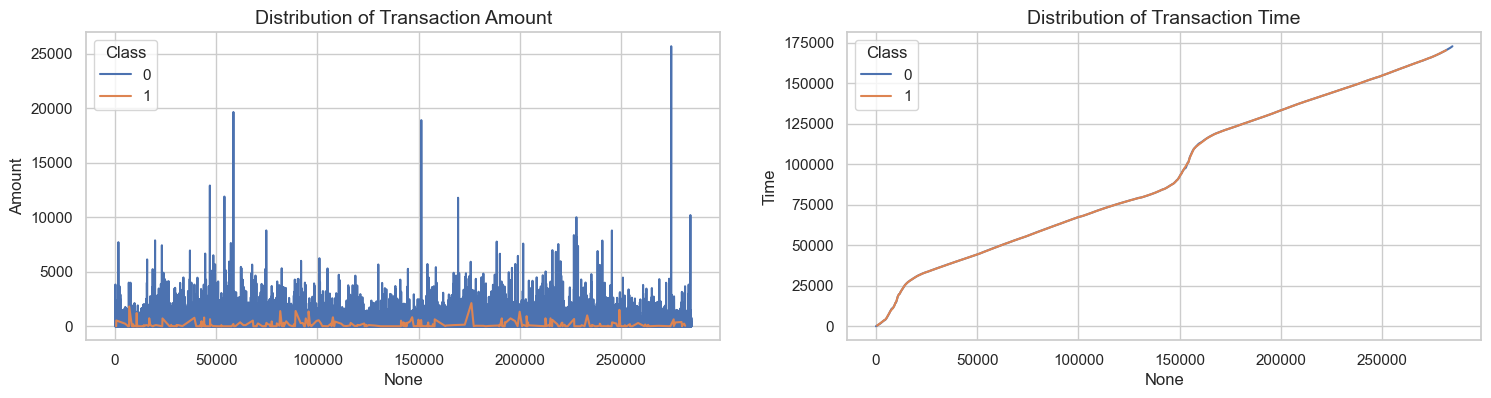

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df[['Amount','Class']]
time_val = df[['Time','Class']]

sns.lineplot(data=amount_val, x=amount_val.index, y='Amount', hue='Class', ax=ax[0])
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)

sns.lineplot(data=time_val, x=time_val.index, y='Time', hue='Class', ax=ax[1])
ax[1].set_title('Distribution of Transaction Time', fontsize=14)

plt.show()

Tambien podemos ver la distribución del resto de variables.

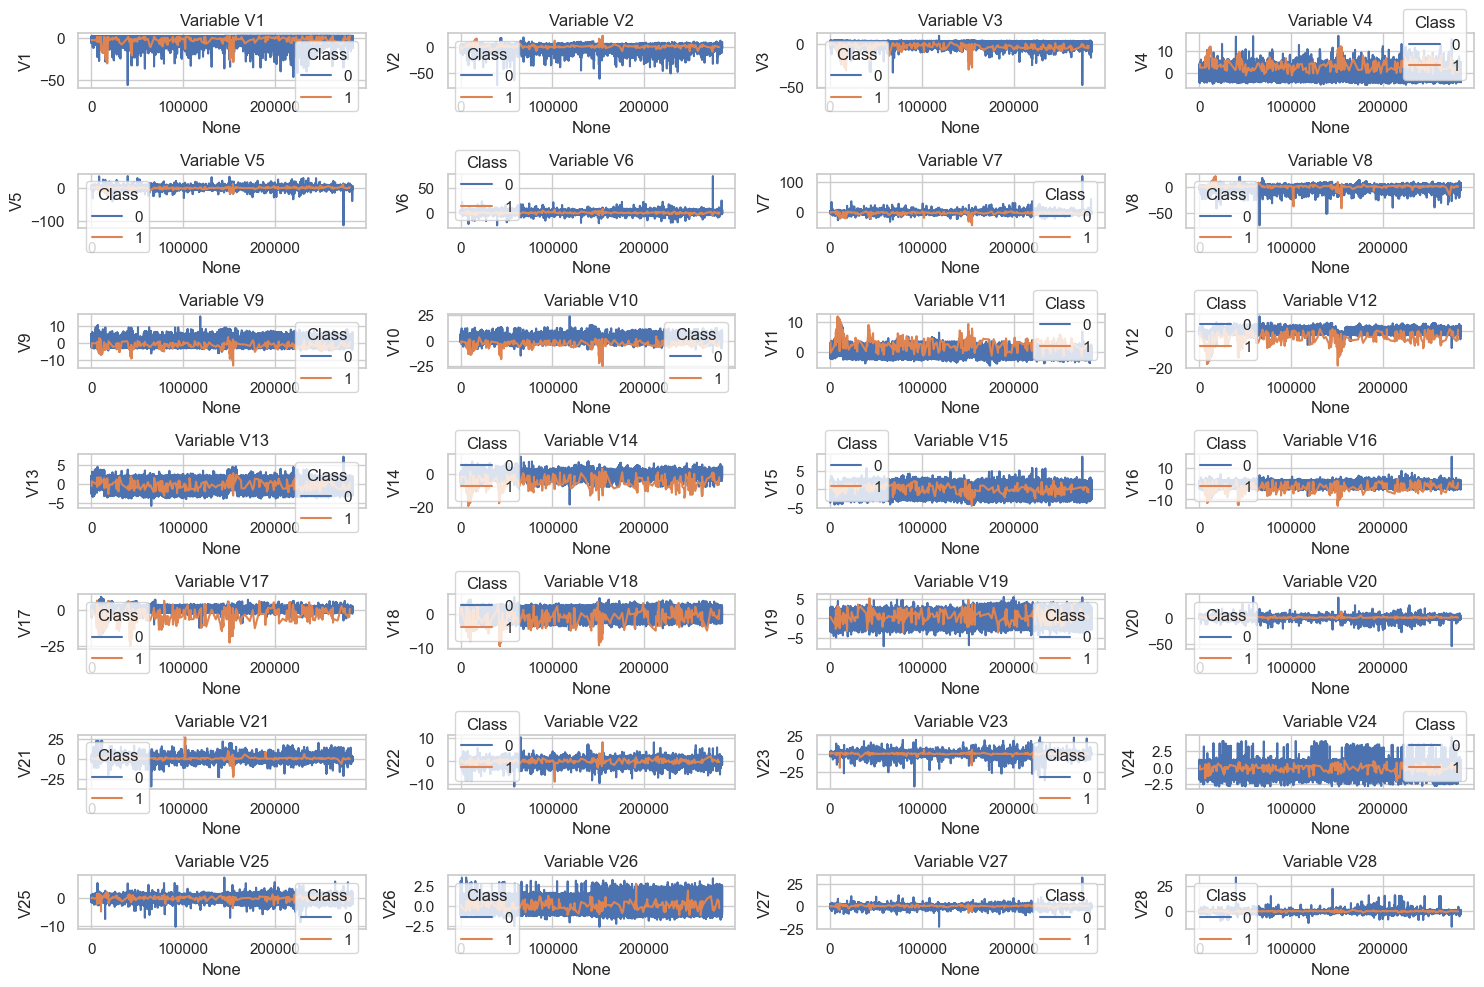

In [27]:
plt.figure(figsize=(15, 10))

for i in range(1, 29):
    plt.subplot(7, 4, i)
    df_p = df[[f'V{i}','Class']]
    sns.lineplot(data=df_p, x=df_p.index, y=f'V{i}', hue='Class')
    plt.title(f'Variable V{i}')
    
plt.tight_layout()
plt.show()

### 3.4. Correlación de las variables con la clase (`Class`)

A continuación analizamos la correlación de cada variable numérica con la variable objetivo `Class`.

En este contexto:

- Nos interesa tanto el **signo** (si valores altos de una variable se asocian a más/menos fraude)  
  como la **intensidad** de la relación.
- Para seleccionar las variables más relacionadas con la clase, utilizaremos el **valor absoluto** de la correlación.


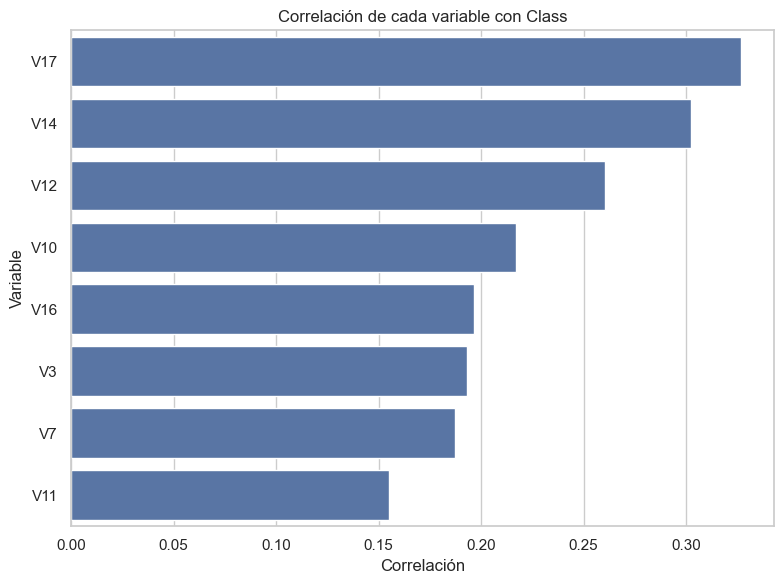

In [28]:
corr_matrix = df.corr(numeric_only=True)
corr_with_class = corr_matrix["Class"].drop("Class")

corr_df = pd.DataFrame({
    "corr": corr_with_class,
    "abs_corr": corr_with_class.abs()
}).sort_values("abs_corr", ascending=False)
top_corr = corr_df.head(8)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_corr["abs_corr"], y=top_corr.index)
plt.title('Correlación de cada variable con Class')
plt.xlabel('Correlación')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()



### 3.5. Distribución de las variables más correlacionadas por clase

Para entender mejor cómo se comportan las variables más importantes en función de la clase, analizamos sus distribuciones separando:

- `Class = 0` (no fraude)
- `Class = 1` (fraude)

Esto nos ayuda a ver si existen rangos de valores claramente asociados a transacciones fraudulentas.

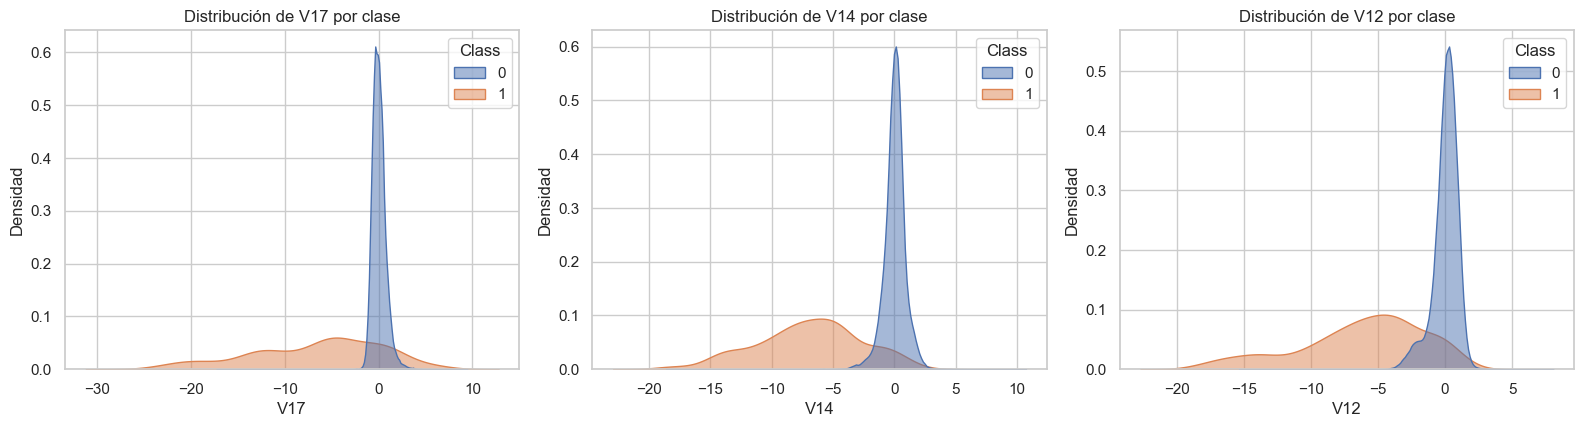

In [29]:
top_vars = corr_df.head(3).index.tolist()

plt.figure(figsize=(16, 8))

for i, col in enumerate(top_vars, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(
        data=df,
        x=col,
        hue="Class",
        common_norm=False,
        fill=True,
        alpha=0.5
    )
    plt.title(f"Distribución de {col} por clase")
    plt.xlabel(col)
    plt.ylabel("Densidad")

plt.tight_layout()
plt.show()


### 3.6. Número de transacciones por hora (fraude vs no fraude)

La variable `Time` representa los segundos transcurridos desde la primera transacción del conjunto.  
Para analizar patrones temporales, es útil aproximar la **hora del día** y ver:

- Cuántas transacciones se realizan en cada hora.
- Cómo se reparte el número de **fraudes** y **no fraudes** a lo largo del tiempo.

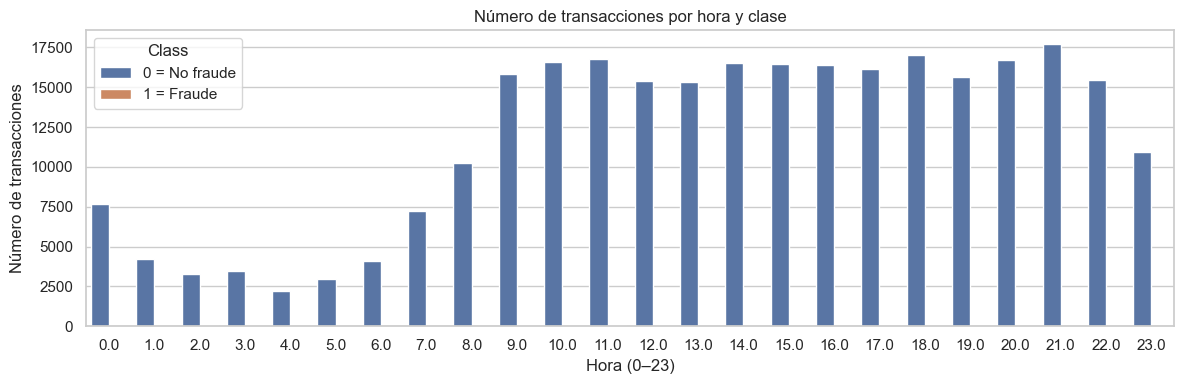

In [30]:
df["Hour"] = (df["Time"] // 3600) % 24
df[["Time", "Hour"]].head()

plt.figure(figsize=(12, 4))
ax = sns.countplot(data=df, x="Hour", hue="Class")

plt.title("Número de transacciones por hora y clase")
plt.xlabel("Hora (0–23)")
plt.ylabel("Número de transacciones")
plt.legend(title="Class", labels=["0 = No fraude", "1 = Fraude"])

plt.tight_layout()
plt.show()


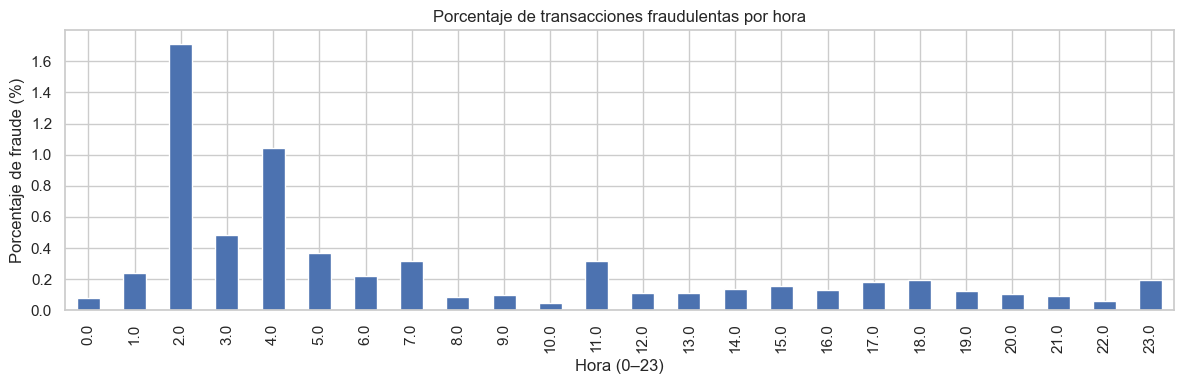

In [31]:
fraud_rate_by_hour = (
    df.groupby("Hour")["Class"]
      .mean() * 100
)

fraud_rate_by_hour = fraud_rate_by_hour.round(4)


plt.figure(figsize=(12, 4))
fraud_rate_by_hour.plot(kind="bar")
plt.title("Porcentaje de transacciones fraudulentas por hora")
plt.xlabel("Hora (0–23)")
plt.ylabel("Porcentaje de fraude (%)")
plt.tight_layout()
plt.show()


Hemos visto que se trata de un dataset fuertemente desbalanceado: hay muchísimas más transacciones legítimas que fraudulentas.
Para abordar este problema existen varias técnicas:

- Oversampling: aumentar la clase minoritaria (fraudes) generando o replicando ejemplos.

- Undersampling: reducir el número de ejemplos de la clase mayoritaria (no fraude).

- Combinación de ambos: ajustar la proporción entre clases sin perder demasiada información ni sobre-replicar fraudes.

Si no tratamos este desbalanceo, los clasificadores tenderán a predecir casi siempre “no fraude” y obtendremos una alta accuracy pero muy mala detección de fraudes, que es precisamente lo que queremos evitar.

## 4. Preparación de los datos para el modelado

Antes de entrenar modelos de clasificación vamos a:

1. Definir las variables de entrada (`X`) y la variable objetivo (`y`).
2. Dividir el dataset en conjuntos de entrenamiento y prueba (`train` / `test`), preservando la proporción de clases.
3. Definir un preprocesado con escalado robusto de las variables `Time` y `Amount`, que se aplicará dentro de un pipeline para evitar fugas de información.


In [32]:
y = df["Class"]

feature_cols = [c for c in df.columns if c not in ["Class", "Hour"]]
X = df[feature_cols]

print("Shape de X:", X.shape)
print("Shape de y:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Shape X_train:", X_train.shape)
print("Shape X_test :", X_test.shape)
print("Distribución de clases en train:\n", y_train.value_counts(normalize=True).round(4))
print("\nDistribución de clases en test:\n", y_test.value_counts(normalize=True).round(4))

n_neg = (y_train == 0).sum()
n_pos = (y_train == 1).sum()
xgb_pos_weight = n_neg / n_pos


Shape de X: (284807, 30)
Shape de y: (284807,)
Shape X_train: (227845, 30)
Shape X_test : (56962, 30)
Distribución de clases en train:
 Class
0    0.9983
1    0.0017
Name: proportion, dtype: float64

Distribución de clases en test:
 Class
0    0.9983
1    0.0017
Name: proportion, dtype: float64


### 4.1. Preprocesado: escalado de `Time` y `Amount`

Las variables `V1`–`V28` ya provienen de una transformación PCA y están aproximadamente estandarizadas.

En cambio:

- `Amount` presenta valores muy dispersos y outliers.
- `Time` es una variable temporal con rango amplio.

Por ello aplicaremos un **RobustScaler** a `Time` y `Amount` y dejaremos el resto de variables tal cual.  
Este preprocesado se definirá con un `ColumnTransformer` y se integrará después en un `Pipeline` junto con los modelos.


In [33]:
num_cols = ["Time", "Amount"]

other_cols = [c for c in feature_cols if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("robust_num", RobustScaler(), num_cols),
        ("passthrough_other", "passthrough", other_cols)
    ]
)

X_train_trans = preprocess.fit_transform(X_train)
X_test_trans = preprocess.transform(X_test)

print("Shape X_train_trans:", X_train_trans.shape)
print("Shape X_test_trans :", X_test_trans.shape)


Shape X_train_trans: (227845, 30)
Shape X_test_trans : (56962, 30)


## 5. Modelado

Empezamos entrenando los modelos sin utilizar tecnicas de resampleo.

Usaremos:

- Un **pipeline** que incluye el preprocesado definido anteriormente (`preprocess`).
- Diferentes modelos utilizados para clasificación binaria.
- La opción `class_weight='balanced'` para mitigar parcialmente el desbalanceo de clases.

El modelo baseline con `threshold = 0.5` logra un recall muy alto en la clase fraude, pero con una precisión muy baja (muchos falsos positivos).

En lugar de quedarnos con el umbral por defecto (0.5), vamos a:

- Calcular la curva *Precision–Recall*.
- Buscar el umbral que maximiza una métrica de equilibrio, como **F1-score** para la clase positiva (fraude).
- Volver a evaluar el modelo con ese umbral ajustado.

In [34]:
base_models = {
    "LogReg": LogisticRegression(
        max_iter=200,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        class_weight="balanced_subsample",
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=xgb_pos_weight,
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=5,
        weights="distance"
    )
}

param_distributions = {
    "LogReg": {
        "clf__C": np.logspace(-3, 3, 10),
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"]
    },
    "RandomForest": {
        "clf__n_estimators": [100, 200, 300, 500],
        "clf__max_depth": [None, 5, 10, 15, 20],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 4]
    },
    "XGBoost": {
        "clf__n_estimators": [200, 300, 500],
        "clf__max_depth": [3, 4, 5, 6],
        "clf__learning_rate": [0.01, 0.05, 0.1, 0.2],
        "clf__subsample": [0.7, 0.8, 1.0],
        "clf__colsample_bytree": [0.7, 0.8, 1.0]
    },
    "KNN": {
        "clf__n_neighbors": [3, 5, 7, 9, 11],
        "clf__weights": ["uniform", "distance"],
        "clf__p": [1, 2]
    }
}

In [35]:
def evaluate_model(model, X_test, y_test, threshold=0.5, title="", model_name=None, sampler=None, threshold_type=None, results_list=None, best_model_info=None, optimize_metric="f1_fraud"):
    y_scores = model.predict_proba(X_test)[:, 1]
    y_pred = (y_scores >= threshold).astype(int)
    
    print(f"=== {title} ===\n")
    print("Informe de clasificación:\n")
    print(classification_report(y_test, y_pred, target_names=["No fraude", "Fraude"]))
    
    roc = roc_auc_score(y_test, y_scores)
    ap = average_precision_score(y_test, y_scores)
    acc = (y_test == y_pred).mean()

    prec_fraud = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec_fraud = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1_fraud = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC: {roc:.4f}")
    print(f"PR-AUC (Average Precision): {ap:.4f}\n")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No fraude", "Fraude"], yticklabels=["No fraude", "Fraude"])
    plt.title(f"Matriz de confusión - {title}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

    current_metrics = {
        "model": model_name or title,
        "sampler": sampler,
        "threshold": threshold,
        "threshold_type": threshold_type,
        "accuracy": acc,
        "precision_fraud": prec_fraud,
        "recall_fraud": rec_fraud,
        "f1_fraud": f1_fraud,
        "roc_auc": roc,
        "pr_auc": ap
    }

    if results_list is not None:
        results_list.append(current_metrics)

    if best_model_info is not None:
        # Elegimos la métrica a optimizar
        if optimize_metric not in current_metrics:
            raise ValueError(f"La métrica '{optimize_metric}' no existe en current_metrics")
        
        current_value = current_metrics[optimize_metric]
        
        if current_value > best_model_info["metric"]:
            print(f">>> Nuevo mejor modelo encontrado según {optimize_metric}: "
                  f"{current_value:.4f} (antes: {best_model_info['metric']:.4f})\n")
            
            best_model_info["metric"] = current_value
            best_model_info["metric_name"] = optimize_metric
            best_model_info["model"] = model        # pipeline entrenado
            best_model_info["model_name"] = model_name or title
            best_model_info["sampler"] = sampler
            best_model_info["threshold"] = threshold
            best_model_info["threshold_type"] = threshold_type
            best_model_info["metrics"] = current_metrics
    
    return y_scores, y_pred


========== Entrenando y evaluando modelo: LogReg ==========

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores hiperparámetros para LogReg :
 {'clf__solver': 'lbfgs', 'clf__penalty': 'l2', 'clf__C': np.float64(2.154434690031882)} 

=== LogReg (threshold=0.5) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      0.98      0.99     56864
      Fraude       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

Accuracy: 0.9755
ROC-AUC: 0.9721
PR-AUC (Average Precision): 0.7189



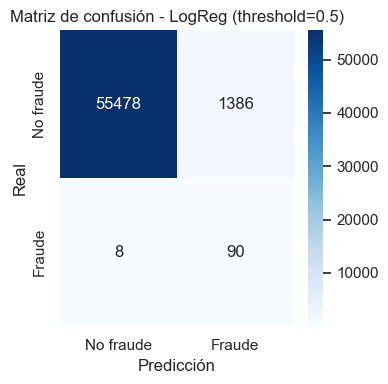

>>> Nuevo mejor modelo encontrado según f1_fraud: 0.1144 (antes: -inf)

Mejor threshold F1 para LogReg: 1.000000
F1 máximo (F1_opt): 0.8247
Precision: 0.8333, Recall: 0.8163

=== LogReg (threshold F1_opt=1.000000) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.82      0.82      0.82        98

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9994
ROC-AUC: 0.9721
PR-AUC (Average Precision): 0.7189



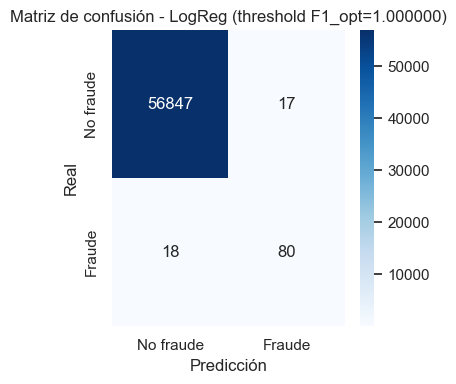

>>> Nuevo mejor modelo encontrado según f1_fraud: 0.8205 (antes: 0.1144)

Mejor threshold F2 para LogReg: 0.999973
F2 máximo (F2_opt): 0.8249
Precision: 0.7810, Recall: 0.8367

=== LogReg (threshold F2_opt=0.999973) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.77      0.84      0.80        98

    accuracy                           1.00     56962
   macro avg       0.89      0.92      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9993
ROC-AUC: 0.9721
PR-AUC (Average Precision): 0.7189



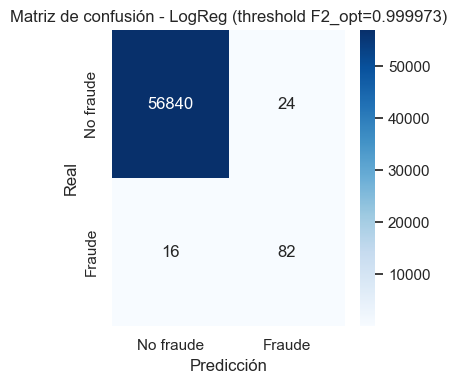


========== Entrenando y evaluando modelo: RandomForest ==========

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros para RandomForest :
 {'clf__n_estimators': 500, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_depth': None} 

=== RandomForest (threshold=0.5) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.95      0.78      0.85        98

    accuracy                           1.00     56962
   macro avg       0.97      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9995
ROC-AUC: 0.9551
PR-AUC (Average Precision): 0.8638



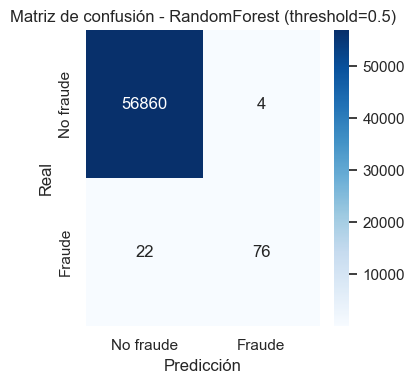

>>> Nuevo mejor modelo encontrado según f1_fraud: 0.8539 (antes: 0.8205)

Mejor threshold F1 para RandomForest: 0.331635
F1 máximo (F1_opt): 0.8723
Precision: 0.9111, Recall: 0.8367

=== RandomForest (threshold F1_opt=0.331635) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.90      0.84      0.87        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9996
ROC-AUC: 0.9551
PR-AUC (Average Precision): 0.8638



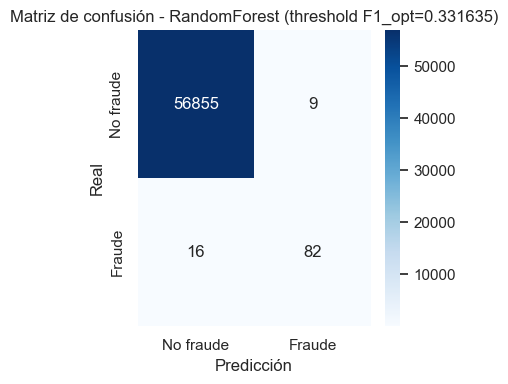

>>> Nuevo mejor modelo encontrado según f1_fraud: 0.8677 (antes: 0.8539)

Mejor threshold F2 para RandomForest: 0.199764
F2 máximo (F2_opt): 0.8621
Precision: 0.8416, Recall: 0.8673

=== RandomForest (threshold F2_opt=0.199764) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.83      0.87      0.85        98

    accuracy                           1.00     56962
   macro avg       0.92      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9995
ROC-AUC: 0.9551
PR-AUC (Average Precision): 0.8638



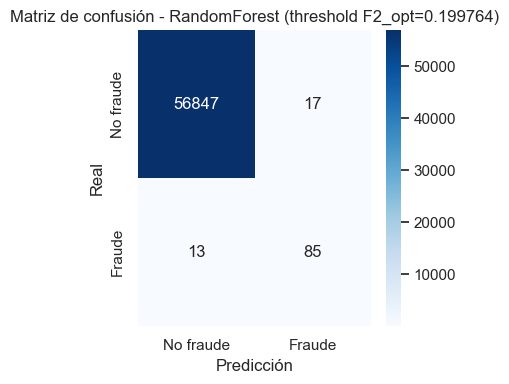


========== Entrenando y evaluando modelo: XGBoost ==========

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros para XGBoost :
 {'clf__subsample': 0.8, 'clf__n_estimators': 500, 'clf__max_depth': 6, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 0.7} 

=== XGBoost (threshold=0.5) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.86      0.84      0.85        98

    accuracy                           1.00     56962
   macro avg       0.93      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9995
ROC-AUC: 0.9792
PR-AUC (Average Precision): 0.8844



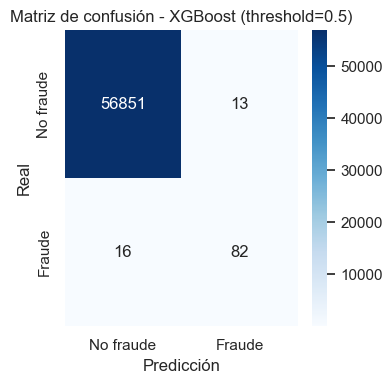

Mejor threshold F1 para XGBoost: 0.914403
F1 máximo (F1_opt): 0.8757
Precision: 0.9310, Recall: 0.8265

=== XGBoost (threshold F1_opt=0.914403) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.92      0.83      0.87        98

    accuracy                           1.00     56962
   macro avg       0.96      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9996
ROC-AUC: 0.9792
PR-AUC (Average Precision): 0.8844



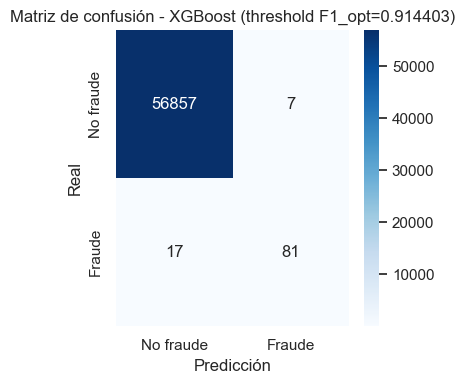

>>> Nuevo mejor modelo encontrado según f1_fraud: 0.8710 (antes: 0.8677)

Mejor threshold F2 para XGBoost: 0.104109
F2 máximo (F2_opt): 0.8652
Precision: 0.8190, Recall: 0.8776

=== XGBoost (threshold F2_opt=0.104109) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.81      0.88      0.84        98

    accuracy                           1.00     56962
   macro avg       0.91      0.94      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9994
ROC-AUC: 0.9792
PR-AUC (Average Precision): 0.8844



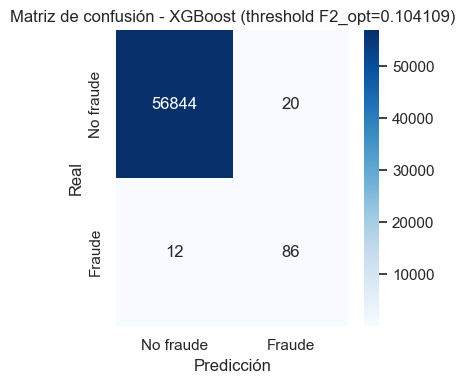


========== Entrenando y evaluando modelo: KNN ==========

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros para KNN :
 {'clf__weights': 'distance', 'clf__p': 1, 'clf__n_neighbors': 11} 

=== KNN (threshold=0.5) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.94      0.76      0.84        98

    accuracy                           1.00     56962
   macro avg       0.97      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9995
ROC-AUC: 0.9437
PR-AUC (Average Precision): 0.8612



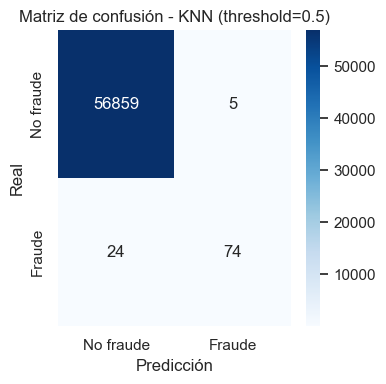

Mejor threshold F1 para KNN: 0.191118
F1 máximo (F1_opt): 0.8643
Precision: 0.8515, Recall: 0.8776

=== KNN (threshold F1_opt=0.191118) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.84      0.88      0.86        98

    accuracy                           1.00     56962
   macro avg       0.92      0.94      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9995
ROC-AUC: 0.9437
PR-AUC (Average Precision): 0.8612



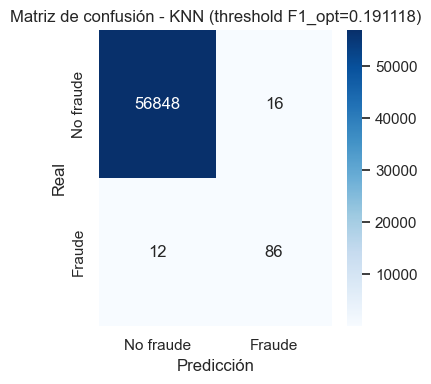

Mejor threshold F2 para KNN: 0.191118
F2 máximo (F2_opt): 0.8722
Precision: 0.8515, Recall: 0.8776

=== KNN (threshold F2_opt=0.191118) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.84      0.88      0.86        98

    accuracy                           1.00     56962
   macro avg       0.92      0.94      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9995
ROC-AUC: 0.9437
PR-AUC (Average Precision): 0.8612



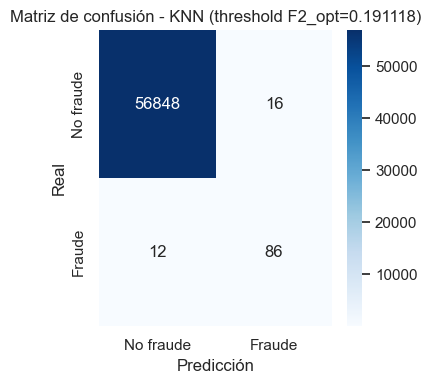

In [36]:
epsilon = 1e-8

for name, clf in base_models.items():
    print(f"\n========== Entrenando y evaluando modelo: {name} ==========\n")
    
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("clf", clf)
    ])
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions[name],
        n_iter=20,
        scoring="average_precision",
        cv=3,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    search.fit(X_train, y_train)
    print("Mejores hiperparámetros para", name, ":\n", search.best_params_, "\n")
    best_pipe = search.best_estimator_
    y_scores = best_pipe.predict_proba(X_test)[:, 1]

    _ = evaluate_model(
        best_pipe,
        X_test,
        y_test,
        threshold=0.5,
        title=f"{name} (threshold=0.5)",
        model_name=name,
        sampler="baseline_multi",
        threshold_type="0.5",
        results_list=experiment_results,
        best_model_info=best_model_info,
        optimize_metric="f1_fraud"
    )
    
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_scores)
    prec_thr = precision_vals[1:]
    rec_thr = recall_vals[1:]
    
    f1_vals = 2 * (prec_thr * rec_thr) / (prec_thr + rec_thr + epsilon)
    best_idx_f1 = np.argmax(f1_vals)
    best_threshold_f1 = thresholds[best_idx_f1]
    
    print(f"Mejor threshold F1 para {name}: {best_threshold_f1:.6f}")
    print(f"F1 máximo (F1_opt): {f1_vals[best_idx_f1]:.4f}")
    print(f"Precision: {prec_thr[best_idx_f1]:.4f}, Recall: {rec_thr[best_idx_f1]:.4f}\n")
    
    _ = evaluate_model(
        best_pipe,
        X_test,
        y_test,
        threshold=best_threshold_f1,
        title=f"{name} (threshold F1_opt={best_threshold_f1:.6f})",
        model_name=name,
        sampler="baseline_multi",
        threshold_type="F1_opt",
        results_list=experiment_results,
        best_model_info=best_model_info,
        optimize_metric="f1_fraud"
    )
    
    beta = 2
    f2_vals = (1 + beta**2) * (prec_thr * rec_thr) / (beta**2 * prec_thr + rec_thr + epsilon)
    best_idx_f2 = np.argmax(f2_vals)
    best_threshold_f2 = thresholds[best_idx_f2]
    
    print(f"Mejor threshold F2 para {name}: {best_threshold_f2:.6f}")
    print(f"F2 máximo (F2_opt): {f2_vals[best_idx_f2]:.4f}")
    print(f"Precision: {prec_thr[best_idx_f2]:.4f}, Recall: {rec_thr[best_idx_f2]:.4f}\n")
    
    _ = evaluate_model(
        best_pipe,
        X_test,
        y_test,
        threshold=best_threshold_f2,
        title=f"{name} (threshold F2_opt={best_threshold_f2:.6f})",
        model_name=name,
        sampler="baseline_multi",
        threshold_type="F2_opt",
        results_list=experiment_results,
        best_model_info=best_model_info,
        optimize_metric="f1_fraud"
    )

## 7. Modelos con oversampling (RandomOverSampler)

Además de usar `class_weight='balanced'`, otra forma de tratar el
desbalanceo es modificar explícitamente la distribución de clases en
el conjunto de entrenamiento.

En esta sección probamos un modelo que combina:

- El mismo preprocesado anterior (`preprocess`).
- Un **RandomOverSampler** para aumentar la clase fraudulenta.
- Una Regresión Logística como clasificador.

Después compararemos sus resultados con el modelo baseline.

Al igual que hicimos con los modelos base, ahora ajustamos el umbral
de decisión de los modelos con `RandomOverSampler` usando la curva
Precision–Recall, con el objetivo de maximizar el F1 (o F2) de la
clase fraude.



========== Entrenando y evaluando modelo: LogReg + ROS ==========

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores hiperparámetros para LogReg :
 {'clf__solver': 'lbfgs', 'clf__penalty': 'l2', 'clf__C': np.float64(2.154434690031882)} 

=== LogReg + ROS  (threshold=0.5) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      0.98      0.99     56864
      Fraude       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

Accuracy: 0.9756
ROC-AUC: 0.9720
PR-AUC (Average Precision): 0.7189



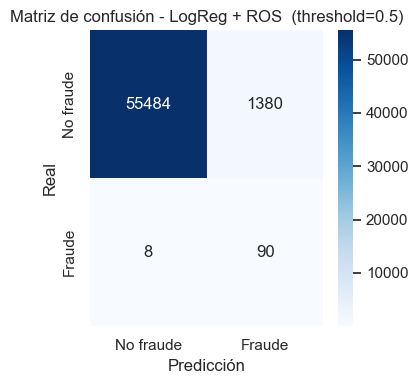

Mejor threshold F1 para LogReg + ROS: 1.000000
F1 máximo (F1_opt): 0.8247
Precision: 0.8333, Recall: 0.8163

=== LogReg + ROS (threshold F1_opt=1.000000) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.82      0.82      0.82        98

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9994
ROC-AUC: 0.9720
PR-AUC (Average Precision): 0.7189



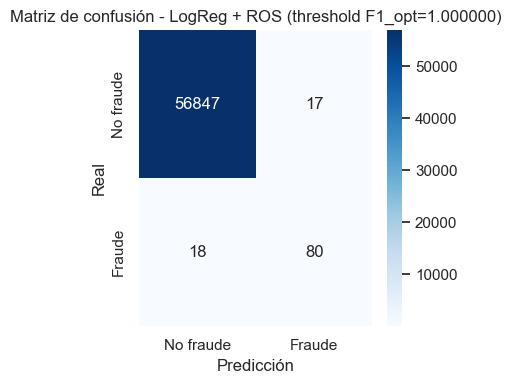

Mejor threshold F2 para LogReg + ROS: 0.999973
F2 máximo (F2_opt): 0.8249
Precision: 0.7810, Recall: 0.8367

=== LogReg + ROS (threshold F2_opt=0.999973) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.77      0.84      0.80        98

    accuracy                           1.00     56962
   macro avg       0.89      0.92      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9993
ROC-AUC: 0.9720
PR-AUC (Average Precision): 0.7189



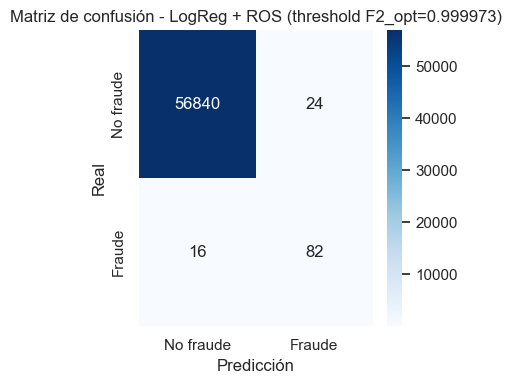


========== Entrenando y evaluando modelo: RandomForest + ROS ==========

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros para RandomForest :
 {'clf__n_estimators': 500, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 2, 'clf__max_depth': None} 

=== RandomForest + ROS  (threshold=0.5) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.94      0.80      0.86        98

    accuracy                           1.00     56962
   macro avg       0.97      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9996
ROC-AUC: 0.9599
PR-AUC (Average Precision): 0.8713



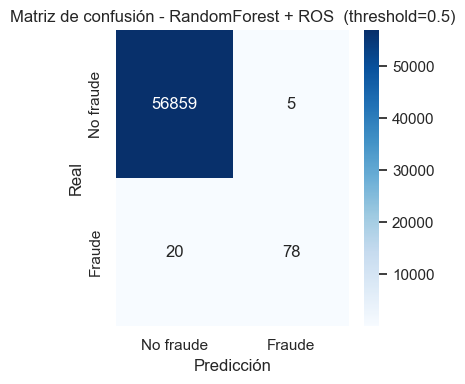

Mejor threshold F1 para RandomForest + ROS: 0.421842
F1 máximo (F1_opt): 0.8804
Precision: 0.9419, Recall: 0.8265

=== RandomForest + ROS (threshold F1_opt=0.421842) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.93      0.83      0.88        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9996
ROC-AUC: 0.9599
PR-AUC (Average Precision): 0.8713



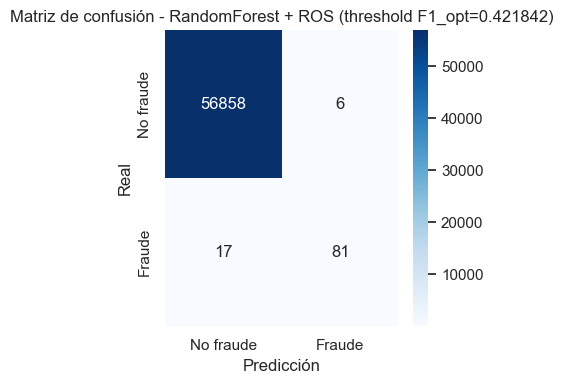

>>> Nuevo mejor modelo encontrado según f1_fraud: 0.8757 (antes: 0.8710)

Mejor threshold F2 para RandomForest + ROS: 0.213858
F2 máximo (F2_opt): 0.8635
Precision: 0.8113, Recall: 0.8776

=== RandomForest + ROS (threshold F2_opt=0.213858) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.80      0.88      0.84        98

    accuracy                           1.00     56962
   macro avg       0.90      0.94      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9994
ROC-AUC: 0.9599
PR-AUC (Average Precision): 0.8713



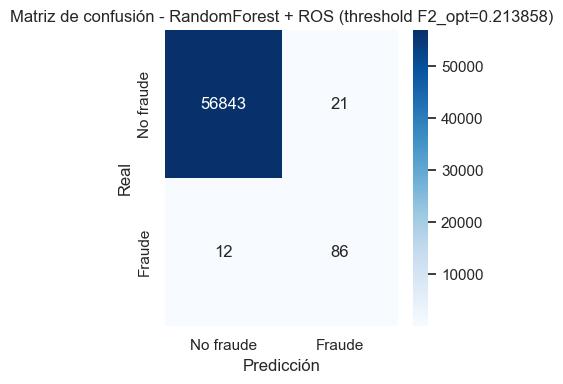


========== Entrenando y evaluando modelo: XGBoost + ROS ==========

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros para XGBoost :
 {'clf__subsample': 0.8, 'clf__n_estimators': 500, 'clf__max_depth': 6, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 0.7} 

=== XGBoost + ROS  (threshold=0.5) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.80      0.87      0.83        98

    accuracy                           1.00     56962
   macro avg       0.90      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9994
ROC-AUC: 0.9852
PR-AUC (Average Precision): 0.8750



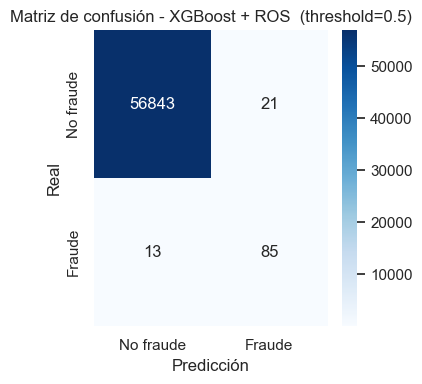

Mejor threshold F1 para XGBoost + ROS: 0.989620
F1 máximo (F1_opt): 0.8791
Precision: 0.9524, Recall: 0.8163

=== XGBoost + ROS (threshold F1_opt=0.989620) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9996
ROC-AUC: 0.9852
PR-AUC (Average Precision): 0.8750



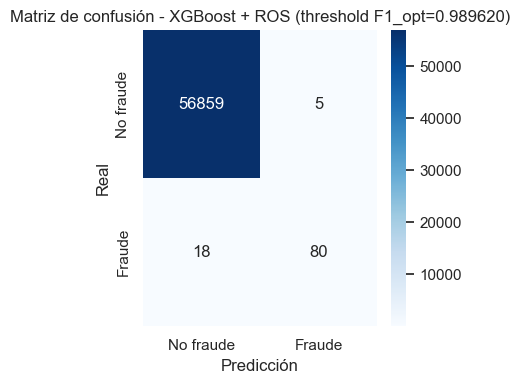

Mejor threshold F2 para XGBoost + ROS: 0.898978
F2 máximo (F2_opt): 0.8642
Precision: 0.8936, Recall: 0.8571

=== XGBoost + ROS (threshold F2_opt=0.898978) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.88      0.86      0.87        98

    accuracy                           1.00     56962
   macro avg       0.94      0.93      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9996
ROC-AUC: 0.9852
PR-AUC (Average Precision): 0.8750



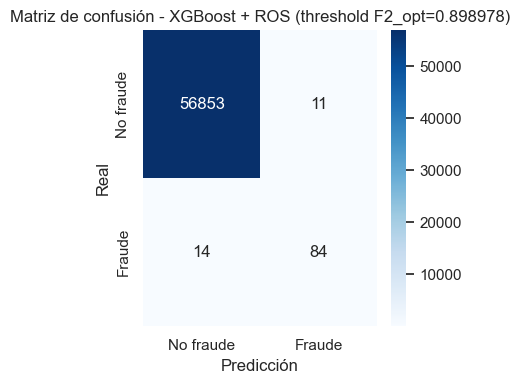


========== Entrenando y evaluando modelo: KNN + ROS ==========

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros para KNN :
 {'clf__weights': 'distance', 'clf__p': 2, 'clf__n_neighbors': 11} 

=== KNN + ROS  (threshold=0.5) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.56      0.89      0.69        98

    accuracy                           1.00     56962
   macro avg       0.78      0.94      0.84     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9986
ROC-AUC: 0.9487
PR-AUC (Average Precision): 0.7589



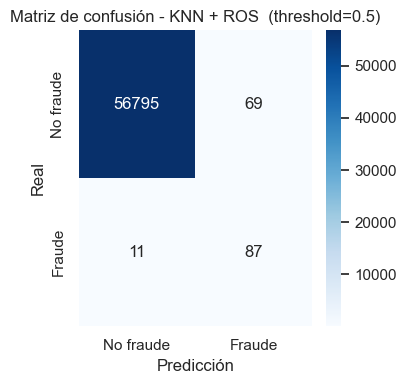

Mejor threshold F1 para KNN + ROS: 0.907746
F1 máximo (F1_opt): 0.8437
Precision: 0.8617, Recall: 0.8265

=== KNN + ROS (threshold F1_opt=0.907746) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.85      0.83      0.84        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9995
ROC-AUC: 0.9487
PR-AUC (Average Precision): 0.7589



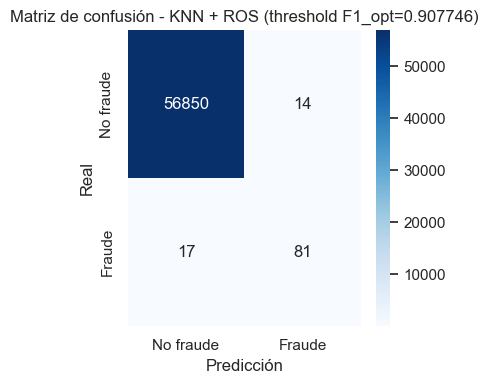

Mejor threshold F2 para KNN + ROS: 0.905318
F2 máximo (F2_opt): 0.8350
Precision: 0.8283, Recall: 0.8367

=== KNN + ROS (threshold F2_opt=0.905318) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.82      0.84      0.83        98

    accuracy                           1.00     56962
   macro avg       0.91      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9994
ROC-AUC: 0.9487
PR-AUC (Average Precision): 0.7589



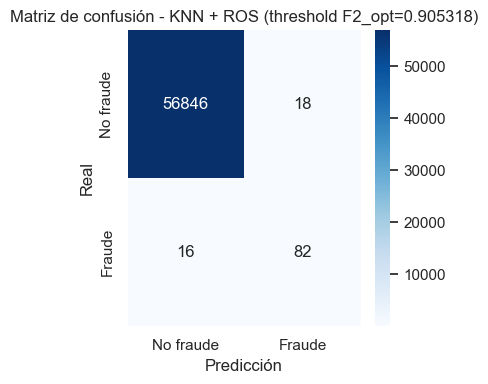

In [37]:
epsilon = 1e-8

for name, clf in base_models.items():
    print(f"\n========== Entrenando y evaluando modelo: {name} + ROS ==========\n")
    
    pipe = ImbPipeline(steps=[
        ("preprocess", preprocess),
        ("sampler", RandomOverSampler(random_state=42)),
        ("clf", clf)
    ])
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions[name],
        n_iter=20,
        scoring="average_precision",
        cv=3,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    search.fit(X_train, y_train)
    print("Mejores hiperparámetros para", name, ":\n", search.best_params_, "\n")
    best_pipe = search.best_estimator_
    y_scores = best_pipe.predict_proba(X_test)[:, 1]
    
    _ = evaluate_model(
        best_pipe,
        X_test,
        y_test,
        threshold=0.5,
        title=f"{name} + ROS  (threshold=0.5)",
        model_name=name,
        sampler="oversampling",
        threshold_type="0.5",
        results_list=experiment_results,
        best_model_info=best_model_info,
        optimize_metric="f1_fraud"
    )
    
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_scores)
    prec_thr = precision_vals[1:]
    rec_thr = recall_vals[1:]
    
    f1_vals = 2 * (prec_thr * rec_thr) / (prec_thr + rec_thr + epsilon)
    best_idx_f1 = np.argmax(f1_vals)
    best_threshold_f1 = thresholds[best_idx_f1]
    
    print(f"Mejor threshold F1 para {name} + ROS: {best_threshold_f1:.6f}")
    print(f"F1 máximo (F1_opt): {f1_vals[best_idx_f1]:.4f}")
    print(f"Precision: {prec_thr[best_idx_f1]:.4f}, Recall: {rec_thr[best_idx_f1]:.4f}\n")
    
    _ = evaluate_model(
        best_pipe,
        X_test,
        y_test,
        threshold=best_threshold_f1,
        title=f"{name} + ROS (threshold F1_opt={best_threshold_f1:.6f})",
        model_name=name,
        sampler="oversampling",
        threshold_type="F1_opt",
        results_list=experiment_results,
        best_model_info=best_model_info,
        optimize_metric="f1_fraud"
    )
    
    beta = 2
    f2_vals = (1 + beta**2) * (prec_thr * rec_thr) / (beta**2 * prec_thr + rec_thr + epsilon)
    best_idx_f2 = np.argmax(f2_vals)
    best_threshold_f2 = thresholds[best_idx_f2]
    
    print(f"Mejor threshold F2 para {name} + ROS: {best_threshold_f2:.6f}")
    print(f"F2 máximo (F2_opt): {f2_vals[best_idx_f2]:.4f}")
    print(f"Precision: {prec_thr[best_idx_f2]:.4f}, Recall: {rec_thr[best_idx_f2]:.4f}\n")
    
    _ = evaluate_model(
        best_pipe,
        X_test,
        y_test,
        threshold=best_threshold_f2,
        title=f"{name} + ROS (threshold F2_opt={best_threshold_f2:.6f})",
        model_name=name,
        sampler="oversampling",
        threshold_type="F2_opt",
        results_list=experiment_results,
        best_model_info=best_model_info,
        optimize_metric="f1_fraud"
    )

## 8. Modelo con undersampling (RandomUnderSampler)

Otra forma de tratar el desbalanceo consiste en **reducir** el número de
ejemplos de la clase mayoritaria (no fraude). Esto es lo que hace el
**RandomUnderSampler**:

- Elimina aleatoriamente instancias de la clase 0.
- Logra una distribución de clases más equilibrada, a costa de perder
  información de la clase mayoritaria.

Es una técnica útil cuando el dataset es muy grande y se puede sacrificar
parte de la información de la clase 0 para ganar velocidad y simplicidad.



========== Entrenando y evaluando modelo: LogReg + RUS ==========

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores hiperparámetros para LogReg :
 {'clf__solver': 'lbfgs', 'clf__penalty': 'l2', 'clf__C': np.float64(1000.0)} 

=== LogReg + RUS  (threshold=0.5) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      0.95      0.98     56864
      Fraude       0.03      0.92      0.07        98

    accuracy                           0.95     56962
   macro avg       0.52      0.94      0.52     56962
weighted avg       1.00      0.95      0.98     56962

Accuracy: 0.9549
ROC-AUC: 0.9756
PR-AUC (Average Precision): 0.6615



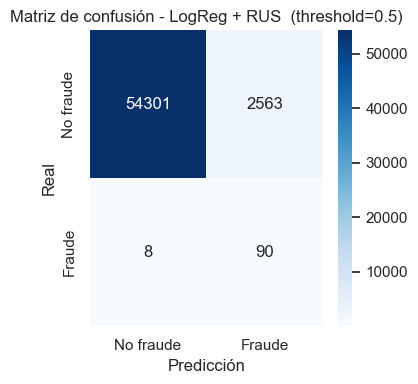

Mejor threshold F1 para LogReg + RUS: 1.000000
F1 máximo (F1_opt): 0.7843
Precision: 0.7547, Recall: 0.8163

=== LogReg + RUS (threshold F1_opt=1.000000) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.75      0.82      0.78        98

    accuracy                           1.00     56962
   macro avg       0.87      0.91      0.89     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9992
ROC-AUC: 0.9756
PR-AUC (Average Precision): 0.6615



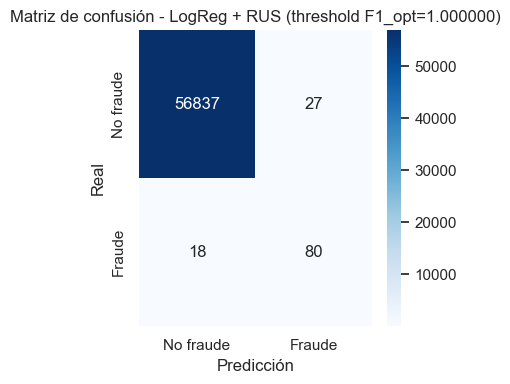

Mejor threshold F2 para LogReg + RUS: 1.000000
F2 máximo (F2_opt): 0.8039
Precision: 0.6949, Recall: 0.8367

=== LogReg + RUS (threshold F2_opt=1.000000) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.69      0.84      0.76        98

    accuracy                           1.00     56962
   macro avg       0.84      0.92      0.88     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9991
ROC-AUC: 0.9756
PR-AUC (Average Precision): 0.6615



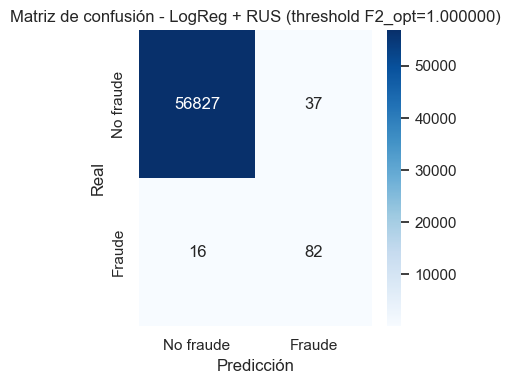


========== Entrenando y evaluando modelo: RandomForest + RUS ==========

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros para RandomForest :
 {'clf__n_estimators': 100, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 2, 'clf__max_depth': None} 

=== RandomForest + RUS  (threshold=0.5) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      0.97      0.98     56864
      Fraude       0.05      0.92      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962

Accuracy: 0.9687
ROC-AUC: 0.9733
PR-AUC (Average Precision): 0.6963



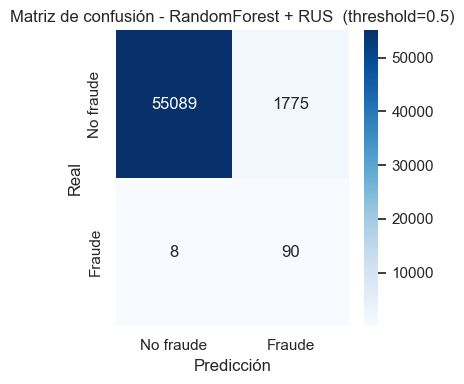

Mejor threshold F1 para RandomForest + RUS: 0.968418
F1 máximo (F1_opt): 0.7849
Precision: 0.8295, Recall: 0.7449

=== RandomForest + RUS (threshold F1_opt=0.968418) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.82      0.74      0.78        98

    accuracy                           1.00     56962
   macro avg       0.91      0.87      0.89     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9993
ROC-AUC: 0.9733
PR-AUC (Average Precision): 0.6963



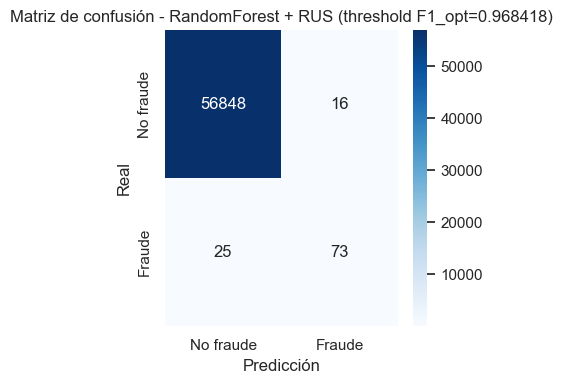

Mejor threshold F2 para RandomForest + RUS: 0.913288
F2 máximo (F2_opt): 0.7797
Precision: 0.6612, Recall: 0.8163

=== RandomForest + RUS (threshold F2_opt=0.913288) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.66      0.82      0.73        98

    accuracy                           1.00     56962
   macro avg       0.83      0.91      0.86     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9989
ROC-AUC: 0.9733
PR-AUC (Average Precision): 0.6963



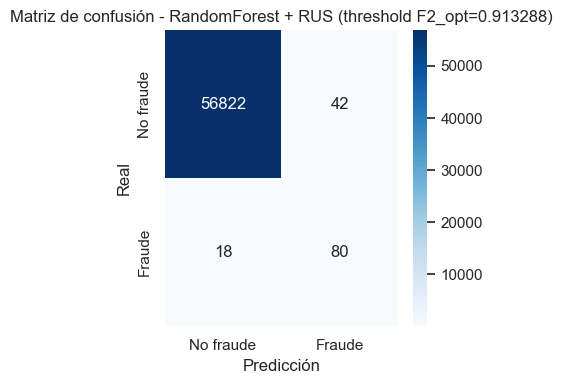


========== Entrenando y evaluando modelo: XGBoost + RUS ==========

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros para XGBoost :
 {'clf__subsample': 0.7, 'clf__n_estimators': 200, 'clf__max_depth': 3, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.7} 

=== XGBoost + RUS  (threshold=0.5) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      0.89      0.94     56864
      Fraude       0.01      0.97      0.03        98

    accuracy                           0.89     56962
   macro avg       0.51      0.93      0.48     56962
weighted avg       1.00      0.89      0.94     56962

Accuracy: 0.8868
ROC-AUC: 0.9860
PR-AUC (Average Precision): 0.7330



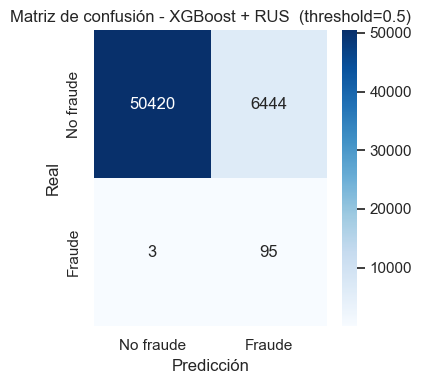

Mejor threshold F1 para XGBoost + RUS: 0.999994
F1 máximo (F1_opt): 0.7310
Precision: 0.7273, Recall: 0.7347

=== XGBoost + RUS (threshold F1_opt=0.999994) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.72      0.73      0.73        98

    accuracy                           1.00     56962
   macro avg       0.86      0.87      0.86     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9991
ROC-AUC: 0.9860
PR-AUC (Average Precision): 0.7330



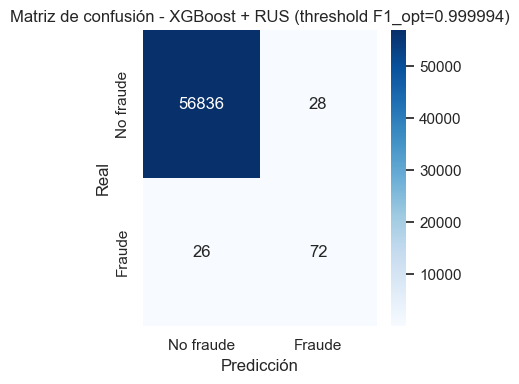

Mejor threshold F2 para XGBoost + RUS: 0.999988
F2 máximo (F2_opt): 0.7558
Precision: 0.6290, Recall: 0.7959

=== XGBoost + RUS (threshold F2_opt=0.999988) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.62      0.80      0.70        98

    accuracy                           1.00     56962
   macro avg       0.81      0.90      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9988
ROC-AUC: 0.9860
PR-AUC (Average Precision): 0.7330



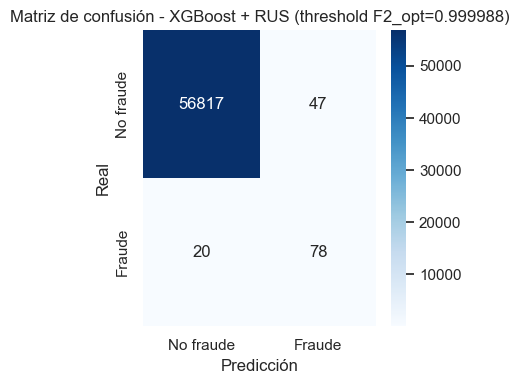


========== Entrenando y evaluando modelo: KNN + RUS ==========

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros para KNN :
 {'clf__weights': 'distance', 'clf__p': 1, 'clf__n_neighbors': 11} 

=== KNN + RUS  (threshold=0.5) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      0.99      0.99     56864
      Fraude       0.10      0.90      0.19        98

    accuracy                           0.99     56962
   macro avg       0.55      0.94      0.59     56962
weighted avg       1.00      0.99      0.99     56962

Accuracy: 0.9865
ROC-AUC: 0.9731
PR-AUC (Average Precision): 0.3848



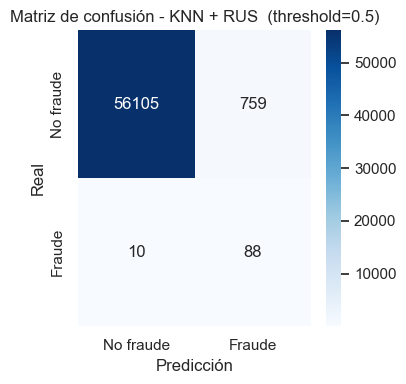

Mejor threshold F1 para KNN + RUS: 0.938601
F1 máximo (F1_opt): 0.5744
Precision: 0.4346, Recall: 0.8469

=== KNN + RUS (threshold F1_opt=0.938601) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.43      0.85      0.57        98

    accuracy                           1.00     56962
   macro avg       0.72      0.92      0.79     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9978
ROC-AUC: 0.9731
PR-AUC (Average Precision): 0.3848



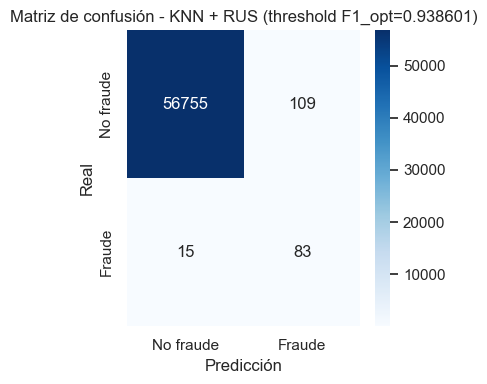

Mejor threshold F2 para KNN + RUS: 0.938601
F2 máximo (F2_opt): 0.7118
Precision: 0.4346, Recall: 0.8469

=== KNN + RUS (threshold F2_opt=0.938601) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.43      0.85      0.57        98

    accuracy                           1.00     56962
   macro avg       0.72      0.92      0.79     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9978
ROC-AUC: 0.9731
PR-AUC (Average Precision): 0.3848



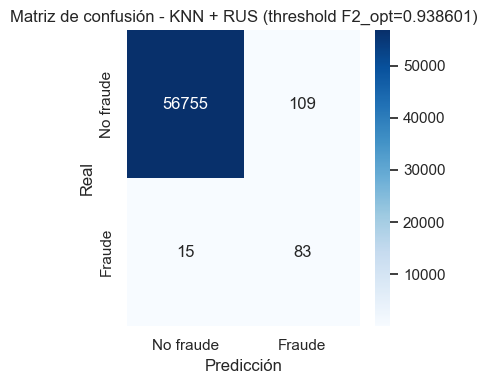

In [38]:
epsilon = 1e-8

for name, clf in base_models.items():
    print(f"\n========== Entrenando y evaluando modelo: {name} + RUS ==========\n")
    
    pipe = ImbPipeline(steps=[
        ("preprocess", preprocess),
        ("under", RandomUnderSampler(random_state=42)),
        ("clf", clf)
    ])
    
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions[name],
        n_iter=20,
        scoring="average_precision",
        cv=3,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    search.fit(X_train, y_train)
    print("Mejores hiperparámetros para", name, ":\n", search.best_params_, "\n")
    best_pipe = search.best_estimator_
    y_scores = best_pipe.predict_proba(X_test)[:, 1]
    
    _ = evaluate_model(
        best_pipe,
        X_test,
        y_test,
        threshold=0.5,
        title=f"{name} + RUS  (threshold=0.5)",
        model_name=name,
        sampler="undersampling",
        threshold_type="0.5",
        results_list=experiment_results,
        best_model_info=best_model_info,
        optimize_metric="f1_fraud"
    )
    
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_scores)
    prec_thr = precision_vals[1:]
    rec_thr = recall_vals[1:]
    
    f1_vals = 2 * (prec_thr * rec_thr) / (prec_thr + rec_thr + epsilon)
    best_idx_f1 = np.argmax(f1_vals)
    best_threshold_f1 = thresholds[best_idx_f1]
    
    print(f"Mejor threshold F1 para {name} + RUS: {best_threshold_f1:.6f}")
    print(f"F1 máximo (F1_opt): {f1_vals[best_idx_f1]:.4f}")
    print(f"Precision: {prec_thr[best_idx_f1]:.4f}, Recall: {rec_thr[best_idx_f1]:.4f}\n")
    
    _ = evaluate_model(
        best_pipe,
        X_test,
        y_test,
        threshold=best_threshold_f1,
        title=f"{name} + RUS (threshold F1_opt={best_threshold_f1:.6f})",
        model_name=name,
        sampler="undersampling",
        threshold_type="F1_opt",
        results_list=experiment_results,
        best_model_info=best_model_info,
        optimize_metric="f1_fraud"
    )

    beta = 2
    f2_vals = (1 + beta**2) * (prec_thr * rec_thr) / (beta**2 * prec_thr + rec_thr + epsilon)
    best_idx_f2 = np.argmax(f2_vals)
    best_threshold_f2 = thresholds[best_idx_f2]
    
    print(f"Mejor threshold F2 para {name} + RUS: {best_threshold_f2:.6f}")
    print(f"F2 máximo (F2_opt): {f2_vals[best_idx_f2]:.4f}")
    print(f"Precision: {prec_thr[best_idx_f2]:.4f}, Recall: {rec_thr[best_idx_f2]:.4f}\n")
    
    _ = evaluate_model(
        best_pipe,
        X_test,
        y_test,
        threshold=best_threshold_f2,
        title=f"{name} + RUS (threshold F2_opt={best_threshold_f2:.6f})",
        model_name=name,
        sampler="undersampling",
        threshold_type="F2_opt",
        results_list=experiment_results,
        best_model_info=best_model_info,
        optimize_metric="f1_fraud"
    )

## 9. Modelo mixto: undersampling + oversampling

También podemos combinar ambas técnicas:

1. **Undersampling** de la clase mayoritaria (no fraude) para reducir su tamaño.
2. **Oversampling** de la clase minoritaria (fraude) para aumentar su representación.

La idea es encontrar un compromiso:
- No perder demasiada información de la clase 0.
- No generar un número excesivo de copias sintéticas/de la clase 1.

A modo de ejemplo, aplicaremos un `RandomUnderSampler` seguido de un
`RandomOverSampler` dentro del mismo pipeline.



========== Entrenando y evaluando modelo: LogReg + RUS&ROS ==========

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores hiperparámetros para LogReg :
 {'clf__solver': 'lbfgs', 'clf__penalty': 'l2', 'clf__C': np.float64(215.44346900318823)} 

=== LogReg + RUS&ROS  (threshold=0.5) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      0.97      0.99     56864
      Fraude       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

Accuracy: 0.9743
ROC-AUC: 0.9751
PR-AUC (Average Precision): 0.7140



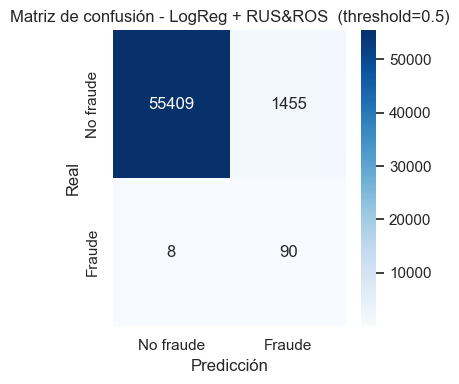

Mejor threshold F1 para LogReg + RUS&ROS: 1.000000
F1 máximo (F1_opt): 0.8247
Precision: 0.8333, Recall: 0.8163

=== LogReg + RUS&ROS (threshold F1_opt=1.000000) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.82      0.82      0.82        98

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9994
ROC-AUC: 0.9751
PR-AUC (Average Precision): 0.7140



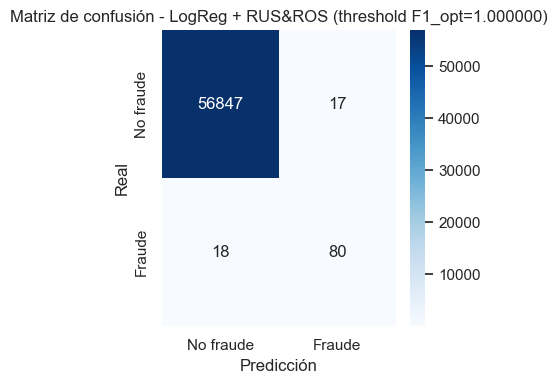

Mejor threshold F2 para LogReg + RUS&ROS: 0.999987
F2 máximo (F2_opt): 0.8233
Precision: 0.7736, Recall: 0.8367

=== LogReg + RUS&ROS (threshold F2_opt=0.999987) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.77      0.84      0.80        98

    accuracy                           1.00     56962
   macro avg       0.88      0.92      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9993
ROC-AUC: 0.9751
PR-AUC (Average Precision): 0.7140



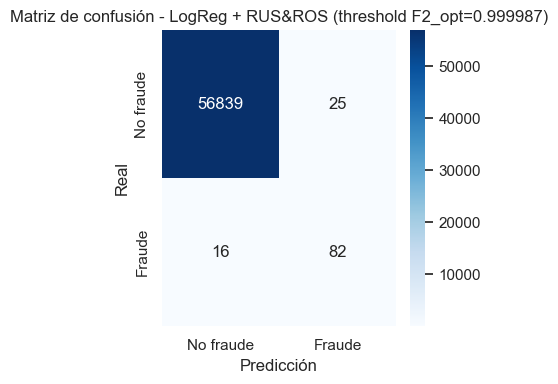


========== Entrenando y evaluando modelo: RandomForest + RUS&ROS ==========

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros para RandomForest :
 {'clf__n_estimators': 300, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 4, 'clf__max_depth': 15} 

=== RandomForest + RUS&ROS  (threshold=0.5) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.33      0.89      0.48        98

    accuracy                           1.00     56962
   macro avg       0.67      0.94      0.74     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9967
ROC-AUC: 0.9813
PR-AUC (Average Precision): 0.7047



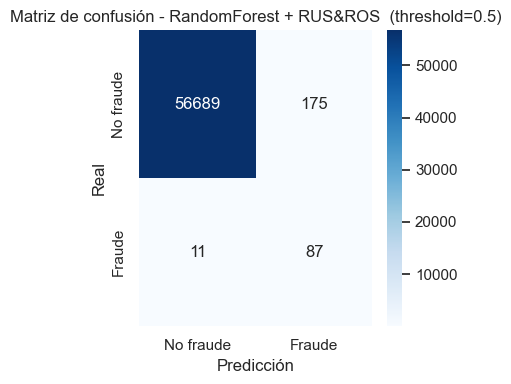

Mejor threshold F1 para RandomForest + RUS&ROS: 0.955177
F1 máximo (F1_opt): 0.8000
Precision: 0.8506, Recall: 0.7551

=== RandomForest + RUS&ROS (threshold F1_opt=0.955177) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.84      0.76      0.80        98

    accuracy                           1.00     56962
   macro avg       0.92      0.88      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9993
ROC-AUC: 0.9813
PR-AUC (Average Precision): 0.7047



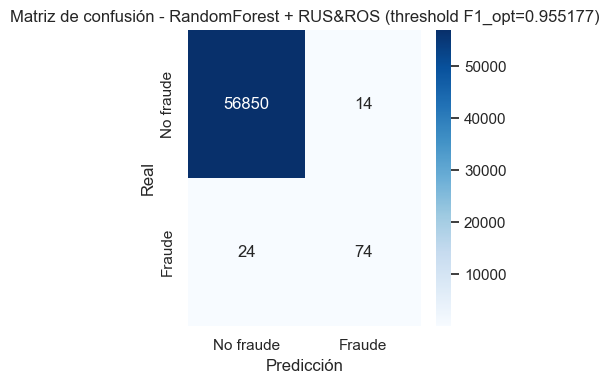

Mejor threshold F2 para RandomForest + RUS&ROS: 0.705659
F2 máximo (F2_opt): 0.8223
Precision: 0.6350, Recall: 0.8878

=== RandomForest + RUS&ROS (threshold F2_opt=0.705659) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.63      0.89      0.74        98

    accuracy                           1.00     56962
   macro avg       0.82      0.94      0.87     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9989
ROC-AUC: 0.9813
PR-AUC (Average Precision): 0.7047



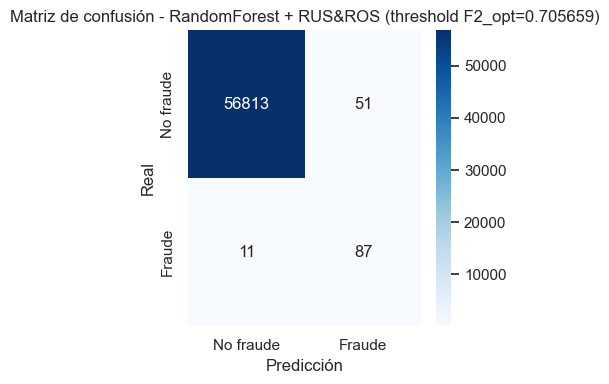


========== Entrenando y evaluando modelo: XGBoost + RUS&ROS ==========

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros para XGBoost :
 {'clf__subsample': 0.7, 'clf__n_estimators': 300, 'clf__max_depth': 3, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.7} 

=== XGBoost + RUS&ROS  (threshold=0.5) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      0.98      0.99     56864
      Fraude       0.07      0.89      0.13        98

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.56     56962
weighted avg       1.00      0.98      0.99     56962

Accuracy: 0.9788
ROC-AUC: 0.9856
PR-AUC (Average Precision): 0.7513



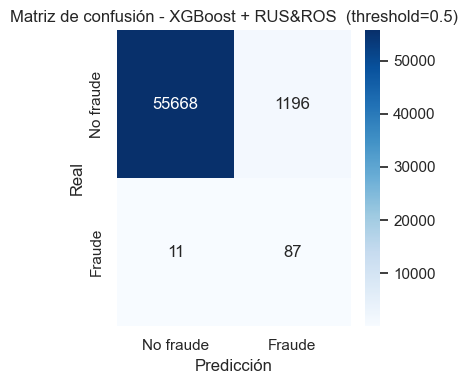

Mejor threshold F1 para XGBoost + RUS&ROS: 0.999989
F1 máximo (F1_opt): 0.7789
Precision: 0.8043, Recall: 0.7551

=== XGBoost + RUS&ROS (threshold F1_opt=0.999989) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.80      0.76      0.77        98

    accuracy                           1.00     56962
   macro avg       0.90      0.88      0.89     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9992
ROC-AUC: 0.9856
PR-AUC (Average Precision): 0.7513



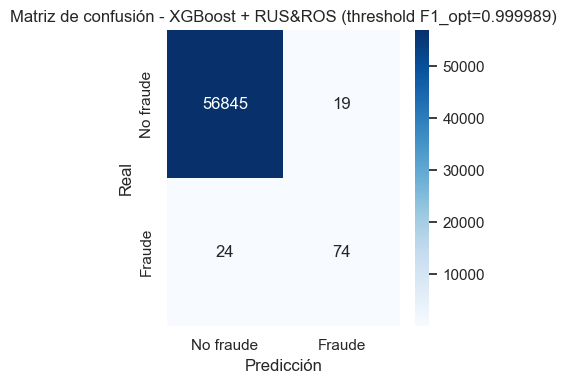

Mejor threshold F2 para XGBoost + RUS&ROS: 0.999650
F2 máximo (F2_opt): 0.8071
Precision: 0.7069, Recall: 0.8367

=== XGBoost + RUS&ROS (threshold F2_opt=0.999650) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00     56864
      Fraude       0.70      0.84      0.76        98

    accuracy                           1.00     56962
   macro avg       0.85      0.92      0.88     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9991
ROC-AUC: 0.9856
PR-AUC (Average Precision): 0.7513



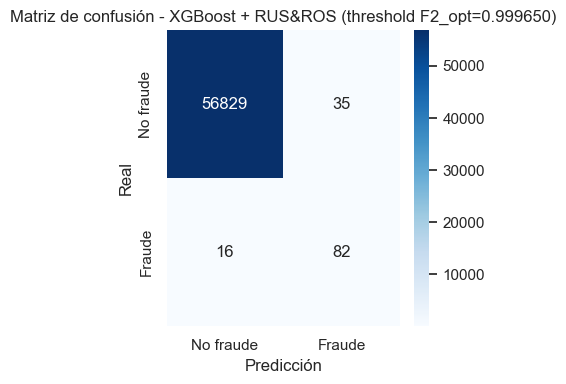


========== Entrenando y evaluando modelo: KNN + RUS&ROS ==========

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros para KNN :
 {'clf__weights': 'distance', 'clf__p': 1, 'clf__n_neighbors': 11} 

=== KNN + RUS&ROS  (threshold=0.5) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      0.96      0.98     56864
      Fraude       0.04      0.93      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.53     56962
weighted avg       1.00      0.96      0.98     56962

Accuracy: 0.9606
ROC-AUC: 0.9633
PR-AUC (Average Precision): 0.1858



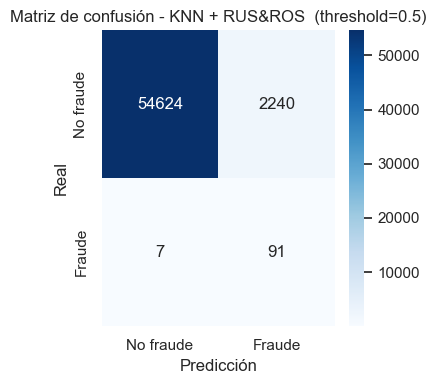

Mejor threshold F1 para KNN + RUS&ROS: 0.957593
F1 máximo (F1_opt): 0.3302
Precision: 0.2028, Recall: 0.8878

=== KNN + RUS&ROS (threshold F1_opt=0.957593) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      0.99      1.00     56864
      Fraude       0.20      0.89      0.33        98

    accuracy                           0.99     56962
   macro avg       0.60      0.94      0.66     56962
weighted avg       1.00      0.99      1.00     56962

Accuracy: 0.9938
ROC-AUC: 0.9633
PR-AUC (Average Precision): 0.1858



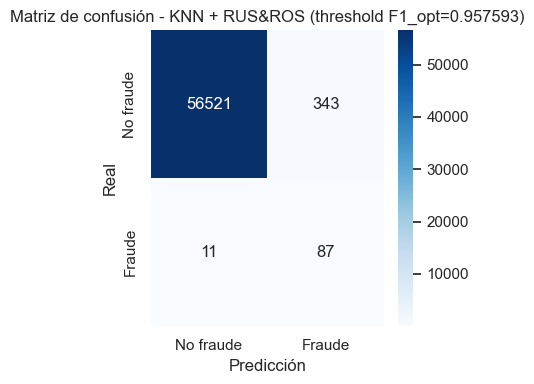

Mejor threshold F2 para KNN + RUS&ROS: 0.957593
F2 máximo (F2_opt): 0.5298
Precision: 0.2028, Recall: 0.8878

=== KNN + RUS&ROS (threshold F2_opt=0.957593) ===

Informe de clasificación:

              precision    recall  f1-score   support

   No fraude       1.00      0.99      1.00     56864
      Fraude       0.20      0.89      0.33        98

    accuracy                           0.99     56962
   macro avg       0.60      0.94      0.66     56962
weighted avg       1.00      0.99      1.00     56962

Accuracy: 0.9938
ROC-AUC: 0.9633
PR-AUC (Average Precision): 0.1858



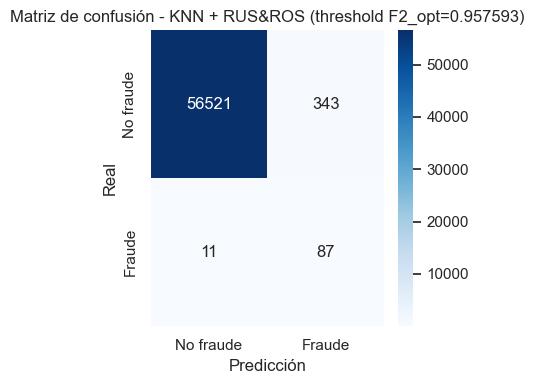

In [39]:
epsilon = 1e-8

for name, clf in base_models.items():
    print(f"\n========== Entrenando y evaluando modelo: {name} + RUS&ROS ==========\n")

    pipe = ImbPipeline(steps=[
        ("preprocess", preprocess),
        ("under", RandomUnderSampler(
            sampling_strategy=0.1,
            random_state=42
        )),
        ("over", RandomOverSampler(
            sampling_strategy=1.0,
            random_state=42
        )),
        ("clf", clf)
    ])
    
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions[name],
        n_iter=20,
        scoring="average_precision",
        cv=3,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    search.fit(X_train, y_train)
    print("Mejores hiperparámetros para", name, ":\n", search.best_params_, "\n")
    best_pipe = search.best_estimator_
    y_scores = best_pipe.predict_proba(X_test)[:, 1]
    
    _ = evaluate_model(
        best_pipe,
        X_test,
        y_test,
        threshold=0.5,
        title=f"{name} + RUS&ROS  (threshold=0.5)",
        model_name=name,
        sampler="undersampling+oversampling",
        threshold_type="0.5",
        results_list=experiment_results,
        best_model_info=best_model_info,
        optimize_metric="f1_fraud"
    )
    
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_scores)
    prec_thr = precision_vals[1:]
    rec_thr = recall_vals[1:]
    
    f1_vals = 2 * (prec_thr * rec_thr) / (prec_thr + rec_thr + epsilon)
    best_idx_f1 = np.argmax(f1_vals)
    best_threshold_f1 = thresholds[best_idx_f1]
    
    print(f"Mejor threshold F1 para {name} + RUS&ROS: {best_threshold_f1:.6f}")
    print(f"F1 máximo (F1_opt): {f1_vals[best_idx_f1]:.4f}")
    print(f"Precision: {prec_thr[best_idx_f1]:.4f}, Recall: {rec_thr[best_idx_f1]:.4f}\n")
    
    _ = evaluate_model(
        best_pipe,
        X_test,
        y_test,
        threshold=best_threshold_f1,
        title=f"{name} + RUS&ROS (threshold F1_opt={best_threshold_f1:.6f})",
        model_name=name,
        sampler="undersampling+oversampling",
        threshold_type="F1_opt",
        results_list=experiment_results,
        best_model_info=best_model_info,
        optimize_metric="f1_fraud"
    )

    beta = 2
    f2_vals = (1 + beta**2) * (prec_thr * rec_thr) / (beta**2 * prec_thr + rec_thr + epsilon)
    best_idx_f2 = np.argmax(f2_vals)
    best_threshold_f2 = thresholds[best_idx_f2]
    
    print(f"Mejor threshold F2 para {name} + RUS&ROS: {best_threshold_f2:.6f}")
    print(f"F2 máximo (F2_opt): {f2_vals[best_idx_f2]:.4f}")
    print(f"Precision: {prec_thr[best_idx_f2]:.4f}, Recall: {rec_thr[best_idx_f2]:.4f}\n")
    
    _ = evaluate_model(
        best_pipe,
        X_test,
        y_test,
        threshold=best_threshold_f2,
        title=f"{name} + RUS&ROS (threshold F2_opt={best_threshold_f2:.6f})",
        model_name=name,
        sampler="undersampling+oversampling",
        threshold_type="F2_opt",
        results_list=experiment_results,
        best_model_info=best_model_info,
        optimize_metric="f1_fraud"
    )

### 10. Comparación de estrategias de muestreo

A partir del `DataFrame` de resultados, podemos extraer las siguientes conclusiones:

- Los modelos **baseline** (solo `class_weight='balanced'`), **con oversampling**
  y **mixtos (under + over)** ofrecen métricas muy similares cuando se ajusta
  correctamente el umbral de decisión (threshold ≈ 1.0):
  - F1 para la clase fraude ≈ 0.82
  - Precisión y recall para fraude en torno a 0.80–0.85
  - ROC-AUC ≈ 0.97 y PR-AUC ≈ 0.72

- El modelo con **undersampling puro** obtiene peores resultados:
  - F1 para fraude ≈ 0.79
  - PR-AUC ≈ 0.69, claramente inferior al resto de estrategias.

En este dataset concreto:

- El uso de oversampling o estrategias mixtas no mejora de forma
  significativa lo que ya se consigue con un modelo sencillo de Regresión
  Logística con `class_weight='balanced'` y un umbral bien optimizado.
- Por simplicidad y robustez, el modelo recomendado como **modelo final**
  es el baseline (Logistic Regression + `class_weight`), usando un
  threshold cercano a 1.0 para equilibrar precisión y recall en la
  detección de fraude.


In [40]:
results_df = pd.DataFrame(experiment_results)
results_df.sort_values("pr_auc", ascending=False)

,model,sampler,threshold,threshold_type,accuracy,precision_fraud,recall_fraud,f1_fraud,roc_auc,pr_auc
6,XGBoost,baseline_multi,0.500000,0.5,0.999491,0.863158,0.836735,0.849741,0.979188,0.884445
7,XGBoost,baseline_multi,0.914403,F1_opt,0.999579,0.920455,0.826531,0.870968,0.979188,0.884445
8,XGBoost,baseline_multi,0.104109,F2_opt,0.999438,0.811321,0.877551,0.843137,0.979188,0.884445
19,XGBoost,oversampling,0.989620,F1_opt,0.999596,0.941176,0.816327,0.874317,0.985232,0.875002
18,XGBoost,oversampling,0.500000,0.5,0.999403,0.801887,0.867347,0.833333,0.985232,0.875002
20,XGBoost,oversampling,0.898978,F2_opt,0.999561,0.884211,0.857143,0.870466,0.985232,0.875002
17,RandomForest,oversampling,0.213858,F2_opt,0.999421,0.803738,0.877551,0.839024,0.959947,0.871312
15,RandomForest,oversampling,0.500000,0.5,0.999561,0.939759,0.795918,0.861878,0.959947,0.871312
16,RandomForest,oversampling,0.421842,F1_opt,0.999596,0.931034,0.826531,0.875676,0.959947,0.871312
4,RandomForest,baseline_multi,0.331635,F1_opt,0.999561,0.901099,0.836735,0.867725,0.955075,0.863752


## 11. Explicabilidad del mejor modelo con SHAP

Para interpretar el comportamiento del mejor modelo obtenido, utilizamos
SHAP (*SHapley Additive exPlanations*), una técnica basada en valores de
Shapley que asigna a cada característica una contribución al resultado
del modelo.

En esta sección veremos:

- La importancia global de las variables (qué features influyen más en
  la predicción de fraude).
- La explicación local de una transacción concreta, especialmente un
  caso de fraude, para entender por qué el modelo la clasifica como tal.


In [41]:
best_model_info

{'metric': 0.8756756756756757,
 'metric_name': 'f1_fraud',
 'model': Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('robust_num', RobustScaler(),
                                                   ['Time', 'Amount']),
                                                  ('passthrough_other',
                                                   'passthrough',
                                                   ['V1', 'V2', 'V3', 'V4', 'V5',
                                                    'V6', 'V7', 'V8', 'V9',
                                                    'V10', 'V11', 'V12', 'V13',
                                                    'V14', 'V15', 'V16', 'V17',
                                                    'V18', 'V19', 'V20', 'V21',
                                                    'V22', 'V23', 'V24', 'V25',
                                                    'V26', 'V27', 'V28'])])),
                 ('sampler', RandomOverSampler(random

In [42]:
# Inicializar visualizaciones de SHAP (para Jupyter)
shap.initjs()

# Recuperamos el mejor modelo desde best_model_info
best_pipe = best_model_info["model"]          # pipeline completo (preprocess + clf)
best_threshold = best_model_info["threshold"]
best_name = best_model_info["model_name"]
best_sampler = best_model_info["sampler"]
best_threshold_type = best_model_info["threshold_type"]

print("Mejor modelo:", best_name)
print("Sampler:", best_sampler)
print("Tipo de threshold:", best_threshold_type)
print("Threshold:", best_threshold)
print("Métrica optimizada:", best_model_info["metric_name"])
print("Valor métrica:", best_model_info["metric"])

Mejor modelo: RandomForest
Sampler: oversampling
Tipo de threshold: F1_opt
Threshold: 0.4218424484491408
Métrica optimizada: f1_fraud
Valor métrica: 0.8756756756756757


In [43]:
# Usamos una muestra de entrenamiento como background (reduce coste de cómputo)
X_background = X_train.sample(n=500, random_state=42)  # puedes ajustar n

# Función de predicción que devuelve la probabilidad de fraude (clase 1)
def model_predict_proba(X):
    """
    X será un DataFrame con las mismas columnas que X.
    Devolvemos la probabilidad de la clase positiva (fraude).
    """
    return best_pipe.predict_proba(X)[:, 1]

# Creamos el explainer de SHAP (modelo tipo caja negra)
explainer = shap.Explainer(model_predict_proba, X_background)

# También creamos una muestra de test para las explicaciones globales
X_test_sample = X_test.sample(n=1000, random_state=42)  # ajustar si quieres
shap_values = explainer(X_test_sample)


PermutationExplainer explainer: 1001it [09:02,  1.83it/s]                          


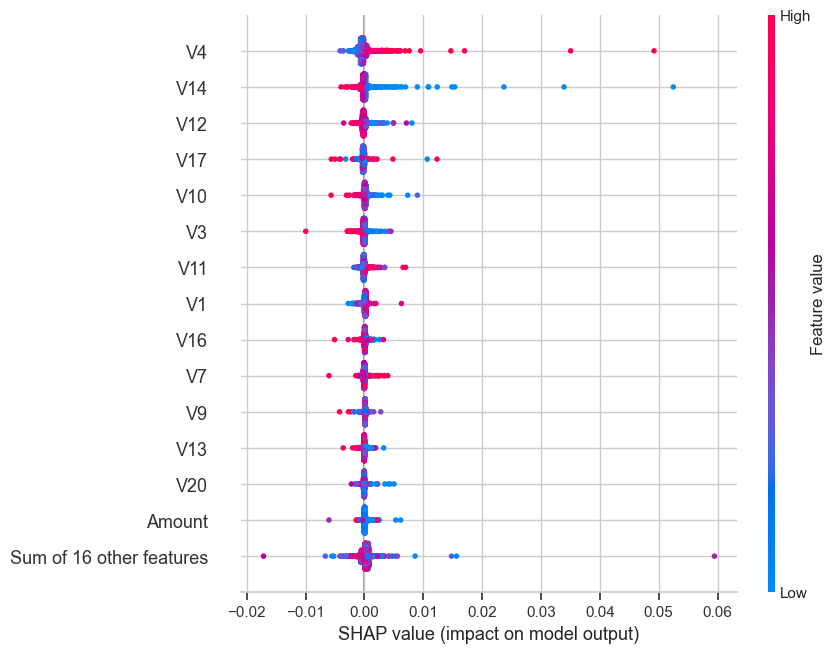

In [44]:
# Gráfico de resumen tipo beeswarm: contribuciones de cada feature
shap.plots.beeswarm(shap_values, max_display=15)


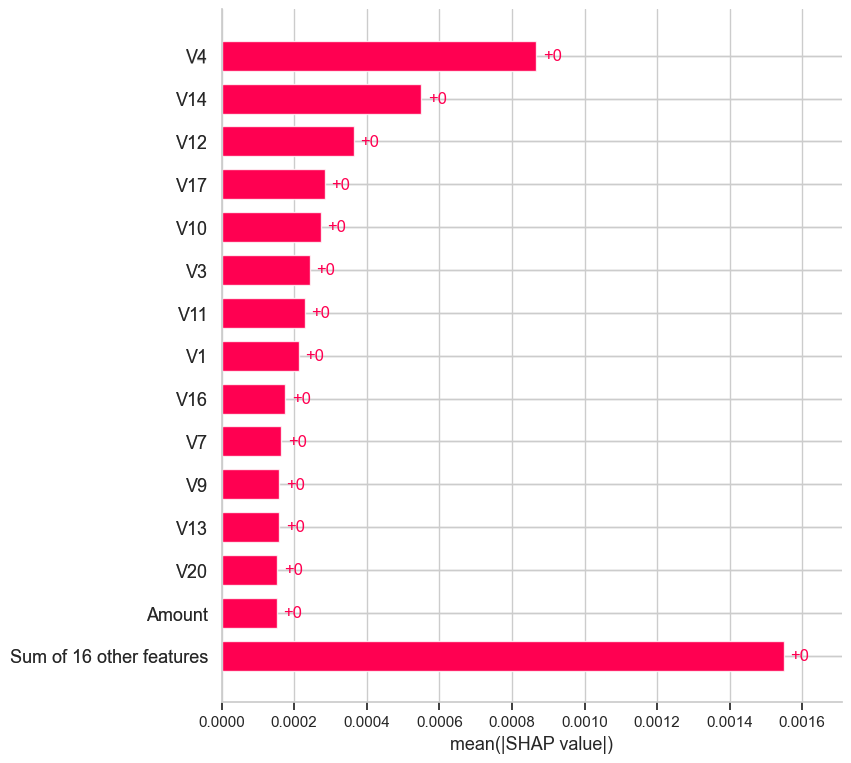

In [45]:
shap.plots.bar(shap_values, max_display=15)

In [46]:
# Seleccionamos una transacción fraudulenta del conjunto de test
fraud_index = y_test[y_test == 1].sample(1, random_state=42).index[0]

x_fraud = X_test.loc[[fraud_index]]  # DataFrame con una sola fila
print("Transacción seleccionada (fraude):", fraud_index)
x_fraud


Transacción seleccionada (fraude): 42528


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
42528,41138.0,-4.595617,5.08369,-7.581015,7.546033,-6.949165,-1.729185,-8.190192,2.71467,-7.083169,-11.141278,7.381859,-14.468655,0.29966,-13.602211,0.516113,-13.563273,-23.815636,-9.170557,3.669523,1.68216,2.248971,0.566844,0.033744,0.591783,0.334229,0.386801,2.163898,0.983104,340.11


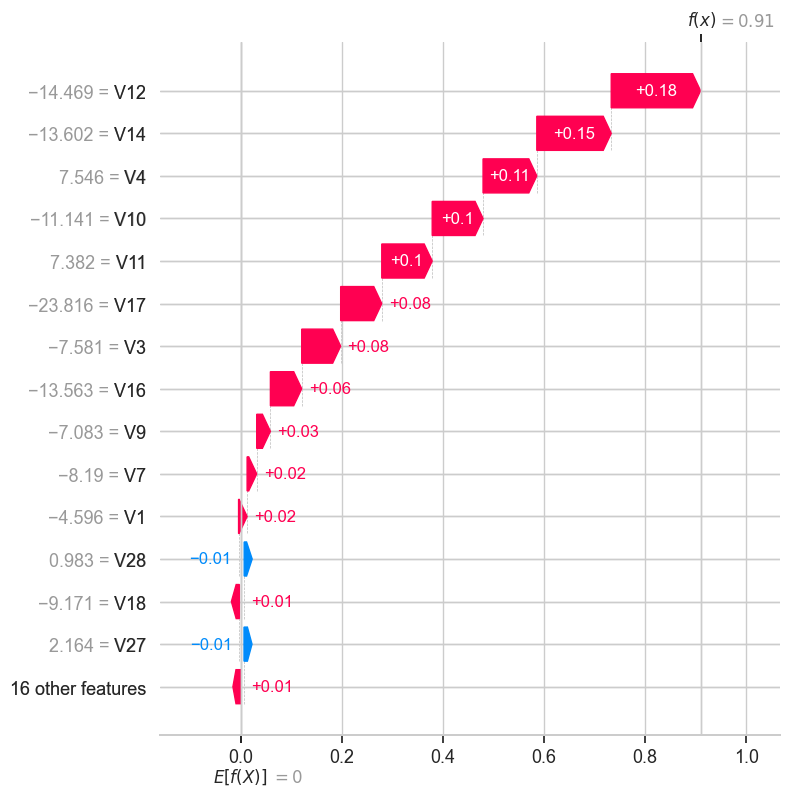

In [47]:
shap_fraud = explainer(x_fraud)

# Gráfico tipo waterfall para ver contribución de cada variable
shap.plots.waterfall(shap_fraud[0], max_display=15)


Transacción seleccionada (no fraude): 197288


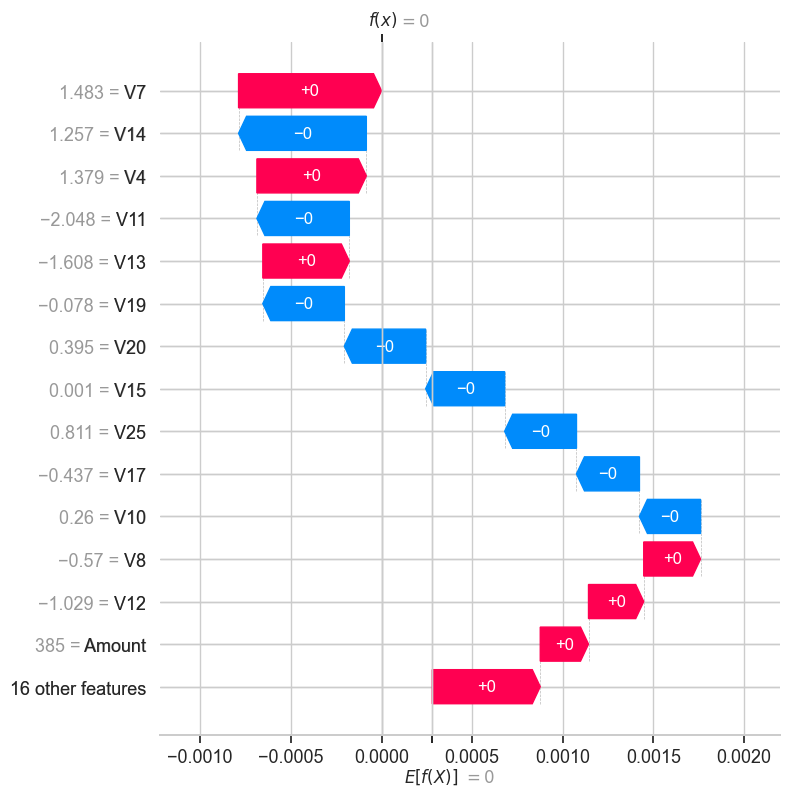

In [48]:
nonfraud_index = y_test[y_test == 0].sample(1, random_state=42).index[0]

x_nonfraud = X_test.loc[[nonfraud_index]]
print("Transacción seleccionada (no fraude):", nonfraud_index)
x_nonfraud

shap_nonfraud = explainer(x_nonfraud)
shap.plots.waterfall(shap_nonfraud[0], max_display=15)


### Conclusión sobre la explicabilidad

Mediante SHAP hemos podido:

- Identificar las variables con mayor impacto global en la detección de
  fraude (por ejemplo, ciertas componentes PCA como Vxx, junto con
  `Amount` o `Time`, según el modelo).
- Analizar casos concretos de transacciones fraudulentas y no
  fraudulentas, observando qué características hacen que el modelo
  incremente o reduzca la probabilidad de fraude.

Este tipo de análisis es especialmente útil en problemas de fraude,
donde es importante no solo obtener buenas métricas de detección, sino
también disponer de argumentos interpretables que apoyen las decisiones
tomadas por el modelo en un entorno real.
